# Cosmic Variance

**1. Theoretical Framework**

* **Cosmic Variance:** This refers to the inherent uncertainty in our understanding of the large-scale structure of the universe. Due to the finite size of our observable universe, we only have a limited sample of the cosmic density field. This leads to statistical fluctuations in the observed distribution of matter, even if our cosmological model is perfectly accurate.
* **Dark Matter Correlation Function:** This function describes how the density of dark matter is correlated at different spatial separations. It's a key ingredient in understanding the distribution of matter in the universe.
* **Galaxy Bias:** Galaxies are not perfectly tracers of the underlying dark matter distribution. Galaxy bias accounts for the fact that galaxies may preferentially form in regions of higher or lower dark matter density. 
* **Halomod:** This is a theoretical framework that describes the clustering of dark matter halos, which are the sites of galaxy formation. It provides a way to connect the properties of dark matter halos to the observed properties of galaxies.

**2. Computing Cosmic Variance**

1. **Calculate the Dark Matter Correlation Function:**
   - Use cosmological simulations or theoretical models (like the Halomod framework) to predict the dark matter correlation function, ξ_mm(r), as a function of separation (r).
2. **Incorporate Galaxy Bias:**
   - **Linear Bias:** For small-scale fluctuations, galaxy bias can often be approximated as a linear relationship:
      ξ_gg(r) = b^2 * ξ_mm(r) 
      where ξ_gg(r) is the galaxy-galaxy correlation function and 'b' is the galaxy bias parameter.
   - **Non-linear Bias:** On smaller scales, non-linear effects become important. These can be incorporated into the Halomod framework using more sophisticated bias models.
3. **Calculate the Variance:**
   - The cosmic variance associated with the galaxy-galaxy correlation function can be estimated by considering the variance of the underlying dark matter density field within the survey volume. 
   - This typically involves integrating the power spectrum of the density fluctuations over the relevant scales.

**3. Using Halomod**

* **Halomod provides a flexible framework for modeling the connection between dark matter halos and galaxies.**
* It allows you to:
    - Model the distribution of dark matter within halos (e.g., using the Navarro-Frenk-White profile).
    - Account for the occupation of halos by galaxies (how many galaxies reside in halos of different masses).
    - Incorporate various bias models to connect galaxy clustering to the underlying dark matter distribution.
* **To use Halomod for this calculation:**
    - Implement the necessary functions within the Halomod framework to calculate the galaxy-galaxy correlation function given the dark matter correlation function and the chosen bias model.
    - Use the Halomod framework to calculate the variance of the galaxy-galaxy correlation function within the survey volume.

**4. Important Considerations**

* **Survey Geometry:** The shape and size of the survey volume will significantly impact the level of cosmic variance.
* **Redshift Dependence:** Both the dark matter correlation function and galaxy bias can evolve with redshift.
* **Systematic Errors:** Be sure to carefully consider and account for potential systematic errors in your analysis, such as observational biases and uncertainties in cosmological parameters.

**Software Tools**

* **Python:** The Halomod framework is often implemented in Python, making it a convenient choice for these calculations.
* **Cosmological Simulation Codes:** Codes like GADGET, PKDGRAV, and others can be used to generate mock galaxy catalogs and directly measure the impact of cosmic variance.



In [892]:
import astropy.io.fits as fits
import numpy as np
from numpy import array

from scipy.integrate import quad
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from scipy import stats

from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u
from astropy.table import Table,join
import os
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import Planck15
import treecorr


#import arviz as az
#import pandas as pd
import pymc as pm
from pymc import HalfCauchy, Model, Normal, sample

%matplotlib inline

import halomod as hm
import hmf

import astropy.io.fits as pyfits
import copy
import sys



In [893]:
directory_SN_X3 = "/home/astro/manasoi7/Master_Thesis/Results/SN-X3"
directory_SN_C3 = "/home/astro/manasoi7/Master_Thesis/Results/SN-C3"
directory_SN_E2 = "/home/astro/manasoi7/Master_Thesis/Results/SN-E2" 
directory_COSMOS = "/home/astro/manasoi7/Master_Thesis/Results/COSMOS" 


home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')
res = os.path.join(home_dir, 'Master_Thesis', 'Results')


In [894]:


# Define the path to the data directory relative to the current script
data_dir = os.path.join("/home/astro/manasoi7/Master_Thesis/DATA") 

# Define file names
cat_files = ["COSMOS_masked_cat.fits", "SN-C3_masked_cat.fits",  
             "SN-X3_masked_cat.fits", "SN-E2_masked_cat.fits"]

zm_files = ["Y3_deep_fields_DB_wKNN_cat_COSMOS_zm.fits", 
            "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits",  
            "Y3_deep_fields_DB_wKNN_cat_SN-X3_zm.fits", 
            "Y3_deep_fields_DB_wKNN_cat_SN-E2_zm.fits"]

rand_files = ["COSMOS_randoms_ugriz_trim_video.fits", 
              "SN-C3_randoms_ugriz_trim_video.fits",  
              "SN-X3_randoms_ugriz_trim_video.fits", 
              "SN-E2_randoms_ugriz_trim_video.fits"]

names = ['COSMOS', 'SN-C3', 'SN-X3', 'SN-E2']

# Create full file paths
cat_full_paths = [os.path.join(data_dir, f) for f in cat_files]
zm_full_paths = [os.path.join(data_dir, f) for f in zm_files]
rand_full_paths = [os.path.join(data_dir, f) for f in rand_files]

## from William's notebook

In [895]:
def get_w(cat, randoms):    
    data = treecorr.Catalog(ra=cat['ra'],dec=cat['dec'], 
                        ra_units='degrees', dec_units='degrees', npatch=50)
    rand = treecorr.Catalog(ra=randoms['ra'],dec=randoms['dec'], 
                        ra_units='degrees', dec_units='degrees')
    
    dd = treecorr.NNCorrelation(min_sep=0.001, max_sep=2., bin_size=0.2, sep_units='degrees', var_method='bootstrap')
    #var_method='jackknife')
    rr = treecorr.NNCorrelation(min_sep=0.001, max_sep=2., bin_size=0.2, sep_units='degrees')
    dd.process(data)
    rr.process(rand)
    theta = np.exp(dd.meanlogr)
    #print(dd[0],rr[0])
    
    dr = treecorr.NNCorrelation(min_sep=0.001, max_sep=2., bin_size=0.2, sep_units='degrees')
    dr.process(data, rand)
    
    w, varw = dd.calculateXi(rr=rr, dr=dr)
    #w.append(w_)
    #varw.append(varw_)
    
    return w, varw, theta, rr

In [896]:

current_dir = os.path.dirname(os.path.abspath(cat_files[1]))
print(f"Current directory: {current_dir}")

Current directory: /home/astro/manasoi7/Master_Thesis/Code


In [897]:


areas = np.array([1.24, 1.7, 1.52, 1.42])
nobj = []
w = []
varw = []
rr_pairs = []

for i in range(4):
    cat = pyfits.open(cat_full_paths[i])[1].data
    zm = pyfits.open(zm_full_paths[i])[1].data
    randoms = pyfits.open(rand_full_paths[i])[1].data

    
    # sort and match
    cat = cat[np.argsort(cat['id'])]
    zm = zm[np.argsort(zm['id'])]
    cat = cat[np.in1d(cat['id'],zm['id'])]
    zm = zm[np.in1d(zm['id'],cat['id'])]
    cat = cat[(cat['kNN_class']==1)&(cat['bdf_mag_dered_calib_i']<25.)&
              (zm['z']>0.5)&(zm['z']<=0.7)&(zm['SM']>10.0)&(zm['SM']<=11.5)]
    
    print(names[i], len(cat), len(cat)/areas[i])

    w_tmp, varw_tmp, theta, rr_ = get_w(cat, randoms)
    w.append(w_tmp)
    varw.append(varw_tmp)
    rr_pairs.append(rr_)
    nobj.append(len(cat))
    print(w_tmp)

nobj = np.array(nobj)

COSMOS 2642 2130.6451612903224
[ 1.33706211e+00  9.99998224e-01  2.10496709e+00  1.54590766e+00
  1.38250151e+00  5.06667270e-01  9.95327128e-01  7.94418902e-01
  6.79113790e-01  6.37948805e-01  3.64530454e-01  2.78826135e-01
  1.99930186e-01  2.06416414e-01  5.03861316e-02  1.32354599e-01
  1.07115206e-01  9.89944855e-02  8.47685114e-02  7.85512533e-02
  4.69437591e-02  4.24275971e-02  5.67640109e-02  1.61689307e-02
  3.28703946e-02  2.52600826e-02  2.05227774e-03  1.63848729e-02
  3.87857279e-03  6.08941011e-03 -5.65977040e-03 -6.54648547e-03
 -1.45889633e-02 -1.10874440e-02 -1.21275625e-02 -3.19988828e-02
  4.94980927e-02  1.87094270e-01  6.00334106e-01]
SN-C3 3510 2064.7058823529414
[ 2.53401313  2.04849301  1.50328968  1.37473542  1.04692603  1.30109508
  0.88889941  0.71859243  0.64415627  0.64278164  0.56207755  0.46438332
  0.43031185  0.29223908  0.28818229  0.19473214  0.19605225  0.20536797
  0.16362805  0.13161857  0.10759814  0.07714654  0.06946489  0.06737506
  0.04654276

In [898]:

print(np.average(nobj/areas))
nav = np.average(nobj/areas)

# need the bias to get the overdensity
b = 1.7
del_b = ((nobj/areas)/nav - 1) / b
print("del_b",del_b)

2096.646322808518
del_b [ 0.00953872 -0.00896121  0.01902965 -0.01960716]


In [ ]:
fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
for i in range(4):
    ax.errorbar(theta*(0.98+0.02*i), w[i], yerr=np.sqrt(varw[i]), fmt='o', label=names[i])
#ax.errorbar(theta, w, yerr=varw, fmt='.', capsize=6, color='r')
#ax.plot(theta, a_best*(theta)**-0.8,'k:')
ax.set_xlabel(r'$\theta$ (degrees)')
ax.set_ylabel(r'$w(\theta)$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-4,10.])
ax.set_xlim([8e-4,2.])
ax.legend()
plt.show()

In [899]:
x = theta
y = w[0] # COSMOS field
sigma = np.sqrt(varw[i])



with Model() as model:  
    # put our RR pair counts in tensor form    
    rr = pm.Data("rr", rr_pairs[0].npairs, dims="observation")

    # Define priors
    A = HalfCauchy("A", 0.5)
    delta = Normal('delta', -0.8, sigma=2.)
    IC = pm.math.sum(A * (x**delta) * rr) / pm.math.sum(rr)
    y_pred = A * (x**delta) - IC
    
    # Define likelihood
    likelihood = Normal("y", mu=y_pred, sigma=sigma, observed=y, dims="observation")

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    idata = sample(1000, tune=4000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, delta]


Output()

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 9 seconds.


In [900]:
A_mean = np.median(idata.posterior["A"].values)
delta_mean = np.median(idata.posterior["delta"].values)
print(A_mean, np.median(idata.posterior["delta"].values))

0.00543301498574537 -0.8847883650416835


0.010944698936364364


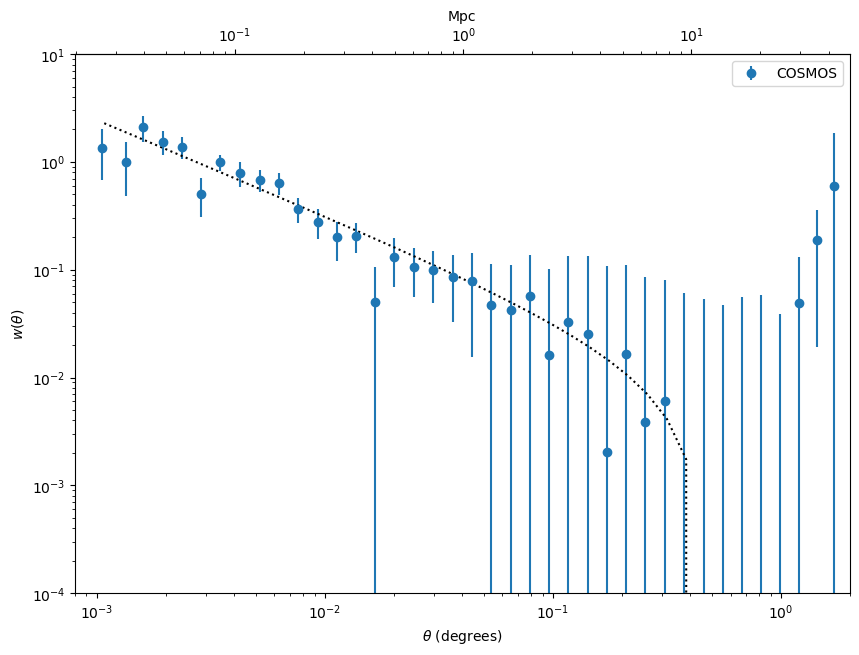

In [901]:
def w_th(A,delta,theta,rr):
    IC = np.sum(A * (theta**delta) * rr / np.sum(rr))
    print(IC)
    return A * (theta**delta) - IC

fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
i=0
#for i in range(4):
ax.errorbar(theta*(0.98+0.02*i), w[i], yerr=np.sqrt(varw[i]), fmt='o', label=names[i])
#ax.errorbar(theta, w, yerr=varw, fmt='.', capsize=6, color='r')
ax.plot(theta, w_th(A_mean,delta_mean,theta,rr_pairs[0].npairs),'k:')
ax.set_xlabel(r'$\theta$ (degrees)')
ax.set_ylabel(r'$w(\theta)$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-4,10.])
ax.set_xlim([8e-4,2.])
secax = ax.secondary_xaxis('top',functions=(lambda x: x*Planck15.kpc_proper_per_arcmin(0.6).value*60./1e3,
                                   lambda x: x*Planck15.arcsec_per_kpc_proper(0.6).value*1e3/3.6e3))
secax.set_xlabel(r'Mpc')
ax.legend()
plt.savefig(os.path.join(directory_COSMOS, "COSMOS_CF.png"))
plt.show()

In [902]:
nz = hm.integrate_corr.flat_z_dist(0.5,0.7)
gg = hm.integrate_corr.AngularCF(nz,nz,p_of_z=True,zmin=0.5,zmax=0.7,z=0.6)
gg.hod_params = {"M_min":13.27, "M_1": 14.6, "alpha":1.}
gg.theta_min = np.min(theta)*np.pi/180
gg.theta_max = np.max(theta)*np.pi/180
gg.theta_num = len(theta)
#gg.hod_params

/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/hmf/density_field/transfer_models.py:233: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(


In [903]:
IC = []
for i in range(4):
    IC_tmp = np.sum(gg.angular_corr_gal*rr_pairs[i].npairs)/np.sum(rr_pairs[i].npairs)
    IC.append(IC_tmp)

print(IC)

[0.019172171581426596, 0.015257753733938697, 0.01668869931263669, 0.016334421596554866]


In [904]:
np.sum((gg.theta*180/np.pi)**(-0.8)*rr_pairs[i].npairs)/np.sum(rr_pairs[i].npairs) * 7.2e-3

0.012226307110042653

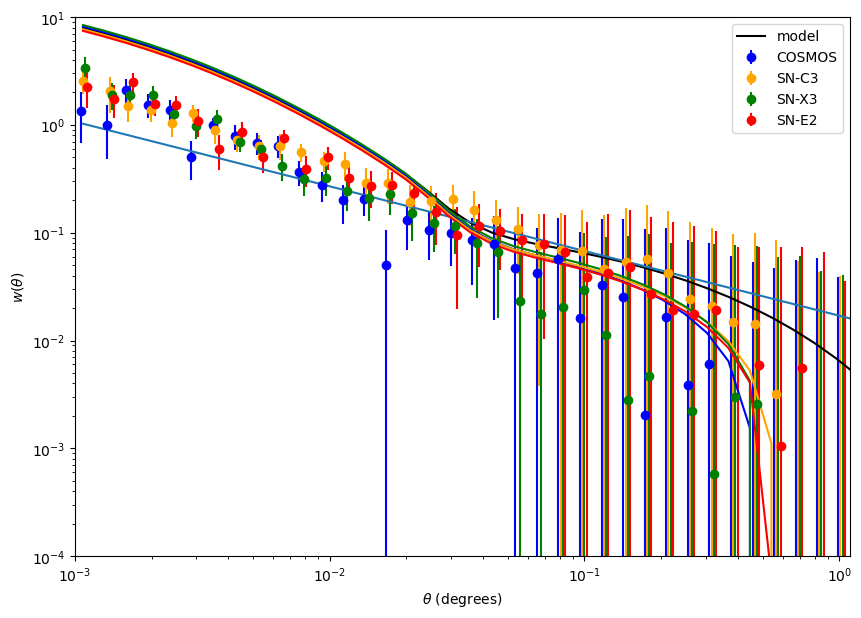

In [905]:
col = ['b', 'orange', 'green', 'red']
fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
for i in range(4):
    ax.errorbar(theta*(0.98+0.02*i), w[i], yerr=np.sqrt(varw[i]), fmt='o', label=names[i], c=col[i])
#ax.errorbar(theta, w, yerr=varw, fmt='.', capsize=6, color='r')
#ax.plot(theta, a_best*(theta)**-0.8,'k:')
ax.plot(gg.theta*180/np.pi, gg.angular_corr_gal, 'k-', label='model')
ax.plot(theta, 0.017*theta**-0.6)

#ax.plot(gg.theta*180/np.pi, gg.angular_corr_matter, '--', c='gray')
for i in range(4):
    ax.plot(gg.theta*180/np.pi, np.exp(del_b[i]*(68/21))*(gg.angular_corr_gal-IC[i]), c=col[i])
#ax.plot(gg.theta*180/np.pi, 7.2e-3*(gg.theta*180/np.pi)**(-0.8)-0.012, '--', c='gray')
ax.set_xlabel(r'$\theta$ (degrees)')
ax.set_ylabel(r'$w(\theta)$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-4,10.])
ax.set_xlim([1e-3,1.1])
ax.legend()
plt.savefig("wtheta_example.png")
plt.show()

In [906]:
print(gg.mean_tracer_den,gg.bias_effective_tracer)

0.0003057584675198279 1.7998801699636766


## now my own

In [907]:
import package.subsample 
import package.subsample_analysis 
import package.correlation_function 
import package.cosmology
import package.bias_calculator

In [908]:
config = {
    'min_sep':  0.003,
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'bootstrap'  # or 'jackknife'
}

In [909]:
COSMOS = np.loadtxt(directory_COSMOS + '/sm_biases.txt', delimiter=',')
X3 = np.loadtxt(directory_SN_X3 + '/sm_biases.txt', delimiter=',')
E2 = np.loadtxt(directory_SN_E2 + '/sm_biases.txt', delimiter=',')
C3 = np.loadtxt(directory_SN_C3 + '/sm_biases.txt', delimiter=',')



COSMOS_reshaped = np.reshape(np.array(COSMOS[:, 1]), (len(z), len(m))).T  
X3_reshaped = np.reshape(np.array(X3[:, 1]), (len(z), len(m))).T  
E2_reshaped = np.reshape(np.array(E2[:, 1]), (len(z), len(m))).T  
C3_reshaped = np.reshape(np.array(C3[:, 1]), (len(z), len(m))).T  

In [910]:

column_sums = []
w_thetas= []

for i in range(21):

    data_SN_E2 = np.loadtxt(os.path.join(directory_SN_E2, f"SN_E2_{i}.txt"), comments='#')
    data_SN_C3 = np.loadtxt(f"output_file_{i}.txt", comments='#')
    data_SN_X3 = np.loadtxt(os.path.join(directory_SN_X3, f"SN_X3_{i}.txt"), comments='#')
    data_COSMOS = np.loadtxt(os.path.join(directory_COSMOS, f"COSMOS_{i}.txt"), comments='#')


    sum_dd = np.sum([data_SN_E2[:, 5], data_SN_C3[:, 5], data_SN_X3[:, 5], data_COSMOS[:, 5]], axis=0)
    sum_rr = np.sum([data_SN_E2[:, 6], data_SN_C3[:, 6], data_SN_X3[:, 6], data_COSMOS[:, 6]], axis=0)
    sum_dr = np.sum([data_SN_E2[:, 7], data_SN_C3[:, 7], data_SN_X3[:, 7], data_COSMOS[:, 7]], axis=0)
    
    w_theta = (sum_dd - 2 * sum_dr + sum_rr) / sum_rr
    w_thetas.append(w_theta)
    
    column_sums.append({
        'catalog_index': i,
        'sum_dd': sum_dd,
        'sum_rr': sum_rr,
        'sum_dr': sum_dr,
        'w_theta': w_theta
        
    })
"""for result in column_sums:
    print(f"Subsample {result['catalog_index']}:")
    #print(f"  Sum of dd : {result['sum_dd']}")
    print(f"  Sum of rr : {result['sum_rr']}")
    #print(f"  Sum of dr : {result['sum_dr']}")
    #print(f"  Sum of w_theta : {result['w_theta']}")
    print()
"""

'for result in column_sums:\n    print(f"Subsample {result[\'catalog_index\']}:")\n    #print(f"  Sum of dd : {result[\'sum_dd\']}")\n    print(f"  Sum of rr : {result[\'sum_rr\']}")\n    #print(f"  Sum of dr : {result[\'sum_dr\']}")\n    #print(f"  Sum of w_theta : {result[\'w_theta\']}")\n    print()\n'

In [912]:
z_values = np.arange(0.3, 1.1, 0.1) 
theta = data_SN_E2[:, 1]

print(theta)

[0.0031496 0.0035157 0.0038613 0.0042923 0.0046872 0.0052279 0.0057686
 0.0063273 0.0069717 0.0077592 0.0085964 0.009459  0.010501  0.011552
 0.012762  0.014109  0.015653  0.017178  0.019063  0.021046  0.023245
 0.025652  0.028375  0.031369  0.034682  0.038257  0.042353  0.046737
 0.051626  0.057008  0.063032  0.069668  0.076917  0.084993  0.093922
 0.10384   0.11464   0.12674   0.14006   0.15475   0.17102   0.18886
 0.20861   0.2306    0.25477   0.28149   0.31114   0.34361   0.37974
 0.41949   0.46352   0.51214   0.56581   0.62515   0.69094   0.76312
 0.84318   0.93156   1.0286    1.1357    1.2544    1.381     1.5249
 1.6799   ]


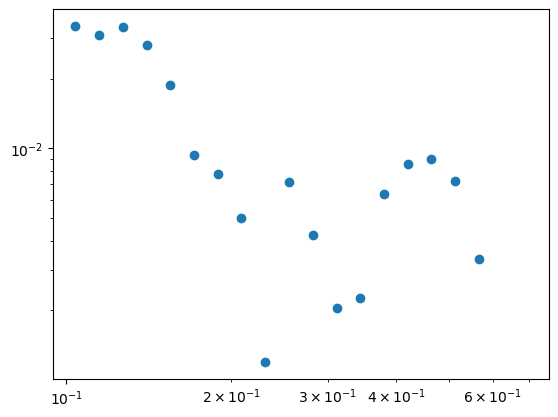

In [913]:
mask = (theta >= 0.1) & (theta <= 0.7)
plt.scatter(theta[mask], w_thetas[4][mask])
plt.yscale('log')
plt.xscale('log')
plt.show()

In [914]:

nz = hm.integrate_corr.flat_z_dist(np.min(z_values), np.max(z_values))
gg = hm.integrate_corr.AngularCF(nz,nz,p_of_z=True,zmin=np.min(z_values),zmax=np.max(z_values),z=np.mean(z_values))
gg.hod_params = {"M_min":13.27, "M_1": 14.6, "alpha":1.}
#gg.theta_min = np.min(thetas[0])*np.pi/180
#gg.theta_max = np.max(thetas[0])*np.pi/180
#gg.theta_num = len(thetas[0])


## Without mask
gg.theta_min = np.min(theta)*np.pi/180 
gg.theta_max = np.max(theta)*np.pi/180 


## With mask
#gg.theta_min = np.min(theta[mask])*np.pi/180
#gg.theta_max = np.max(theta[mask])*np.pi/180

print(gg.angular_corr_gal)

[1.00339140e+00 8.15425954e-01 6.52222548e-01 5.13425968e-01
 3.97841141e-01 3.03349693e-01 2.27592481e-01 1.67737598e-01
 1.20194603e-01 8.35259119e-02 5.79960534e-02 4.14735573e-02
 3.13958223e-02 2.56953892e-02 2.23531591e-02 1.99688772e-02
 1.79142506e-02 1.59529328e-02 1.40241646e-02 1.21344119e-02
 1.03106609e-02 8.58420953e-03 6.98527206e-03 5.54006794e-03
 4.26827571e-03 3.18187102e-03 2.28417828e-03 1.57008987e-03
 1.02657610e-03 6.32175417e-04]


Subsample 0:
[ 0.09838271  0.05427242  0.2731556   0.0306355   0.14276151  0.11242561
  0.23133814  0.16752565  0.02216502  0.13562406  0.08868354  0.09689296
  0.09928562  0.04092689  0.12332003  0.09833065  0.1009906   0.06701423
  0.09758804  0.06394376  0.07419989  0.05683097  0.07691103  0.0443541
  0.03197064  0.01927838  0.0441645   0.02683191  0.04230845  0.02610678
  0.01944018  0.03824427  0.01349952  0.01852297  0.02717385  0.01886866
  0.01180417  0.02305591  0.01861402  0.01332337  0.00775166  0.01000759
  0.00196955  0.00650418  0.00753894  0.0103523   0.00461654  0.00803766
  0.00359228  0.00452949  0.00089458  0.00116529  0.00148304 -0.0034506
 -0.00542486 -0.0053263  -0.00583549 -0.00683943 -0.00619238 -0.0030574
  0.00052516 -0.00053632  0.00088498  0.01642974]


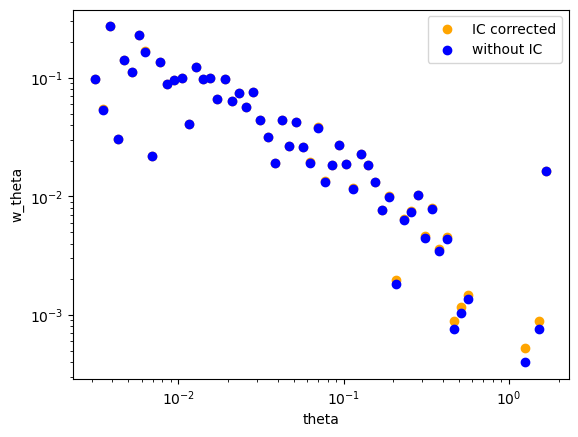

Subsample 1:
[ 0.69154189  0.21997848  0.65551765  0.41802918  0.56042959  0.50077831
  0.37976274  0.31919878  0.36817821  0.2218572   0.2810561   0.28525164
  0.3346244   0.37675142  0.24600533  0.15606484  0.17556866  0.17614594
  0.17856557  0.13452258  0.13353151  0.17433487  0.11243389  0.08647231
  0.11564695  0.07053694  0.10045449  0.08384469  0.06736914  0.06989661
  0.06469259  0.04804631  0.03140659  0.03872602  0.04609359  0.02797434
  0.03731291  0.02079312  0.01626884  0.01100567 -0.00155346 -0.00375632
  0.00443824  0.00634281  0.00532956  0.00382534  0.00533964  0.01133002
  0.00991912  0.01123405  0.00525718 -0.0009952  -0.00070707 -0.00071464
 -0.00159686 -0.00502819 -0.00282833 -0.00688596 -0.00891755 -0.01016367
 -0.00548739 -0.004033   -0.0031139   0.01750917]


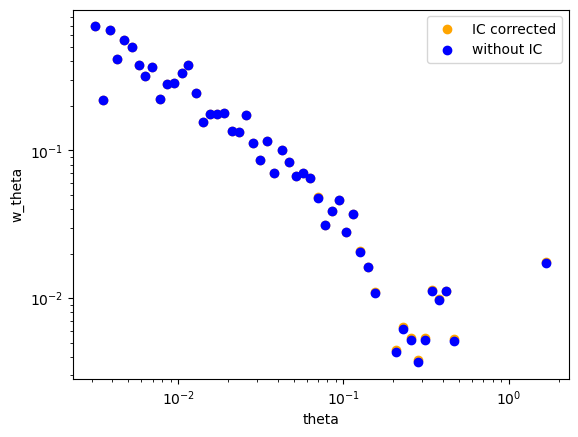

Subsample 2:
[ 1.31282631e+00  6.41144408e-01  6.17754525e-01  8.01960501e-01
  1.19475760e+00  4.91691515e-01  6.32063352e-01  7.01464972e-01
  5.89778916e-01  4.12874213e-01  4.10881171e-01  4.99292424e-01
  4.24155304e-01  2.79217231e-01  2.42748646e-01  3.39325707e-01
  3.18393458e-01  3.11065871e-01  2.23969208e-01  2.07481307e-01
  1.94480799e-01  1.35107538e-01  1.56851405e-01  1.57303439e-01
  1.07212392e-01  1.19328006e-01  1.30410859e-01  9.95838386e-02
  1.00774333e-01  8.42953715e-02  7.78359970e-02  6.00407206e-02
  3.13745166e-02  4.71316694e-02  4.29512144e-02  3.76008405e-02
  3.29223289e-02  3.69381374e-02  1.21600294e-02  1.38444813e-02
  1.69282519e-02  1.46052747e-02  1.46501534e-02  1.86663908e-02
  2.26611819e-02  2.12636222e-02  1.59142780e-02  2.03039397e-02
  5.97726950e-03  1.33978443e-02  1.34419576e-02  4.46977681e-03
  3.88467842e-03 -4.37838400e-03 -4.77721131e-04 -7.70475617e-03
 -4.12422119e-03 -4.43887861e-03 -1.20760521e-02 -1.46631750e-02
 -1.67500370

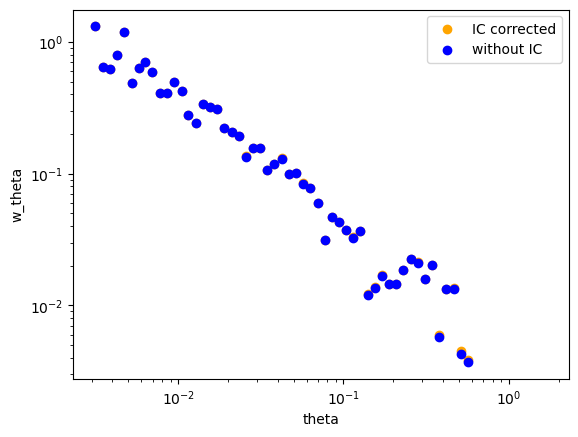

Subsample 3:
[ 2.13344536e-01  1.14967199e-01  5.88474390e-02  9.61325532e-02
  1.17206262e-01  6.26283863e-02  1.40729461e-01  6.96182407e-02
  1.02430204e-01  6.51367457e-02  2.05165120e-02  7.99289510e-02
  9.10169039e-02  8.51750165e-02  4.42644316e-02  3.80552062e-02
  7.65247947e-02  6.05553494e-02  3.95382535e-02  2.70359834e-02
  5.24348232e-02  4.35331705e-02  2.75944384e-02  2.45643594e-02
  3.16036314e-02  7.13687863e-03  3.21881083e-02  2.48889836e-02
  1.45824615e-02  8.12629186e-03  1.88619338e-02  1.33664649e-02
  1.11943373e-02  1.02435014e-02  3.00302072e-03  5.63857612e-03
  1.15328398e-02  1.22917592e-02  8.72846462e-03  7.47497139e-03
  4.08712326e-03  4.24240703e-04  5.38398246e-04  5.05373595e-03
  3.19772378e-04 -9.23015212e-04 -9.92808088e-04  2.20673901e-03
  1.95437228e-04  4.23703333e-03  1.36564260e-03 -2.44988652e-04
  8.84912253e-04 -1.28374185e-04  9.99753387e-04 -1.08037595e-03
 -2.04309260e-03 -4.14282422e-04 -3.20974463e-03 -1.96552384e-03
 -3.33705956

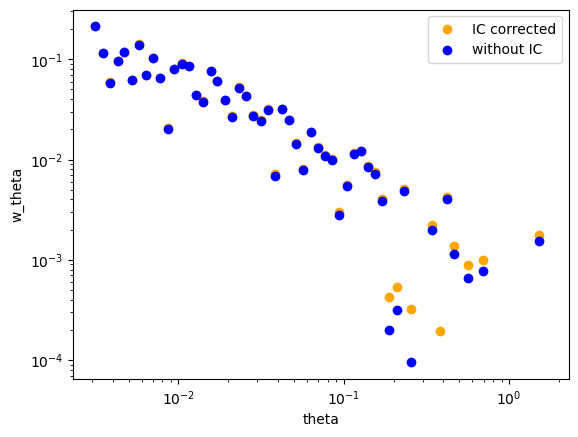

Subsample 4:
[ 0.38746547  0.40233989  0.17746276  0.36006252  0.30710043  0.20722939
  0.35559279  0.24292128  0.27216084  0.30131451  0.16197024  0.19033645
  0.18977169  0.19591582  0.17541317  0.17195153  0.19359975  0.10622506
  0.14428582  0.1160969   0.1181037   0.0834365   0.10499889  0.06022282
  0.09618068  0.08982432  0.06765745  0.05455839  0.0608792   0.06229153
  0.03815728  0.04176768  0.03402675  0.03253411  0.03541605  0.03406101
  0.03099085  0.03380522  0.0283206   0.01901128  0.00960686  0.00801106
  0.00530546  0.00147074  0.00741294  0.00448318  0.00231827  0.00253008
  0.00663708  0.00881707  0.00925246  0.00753266  0.00359935 -0.00109728
 -0.00111398 -0.00228392 -0.00531827 -0.00412421 -0.00642477 -0.00962353
 -0.01306837 -0.00554345  0.00124035 -0.00067618]


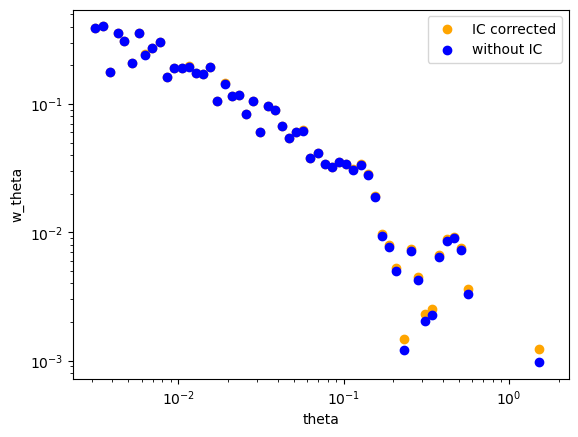

Subsample 5:
[ 0.98030995  0.67732548  0.73813817  0.58578013  0.52751167  0.41710491
  0.4249726   0.45449087  0.26928401  0.4816489   0.39443718  0.27252356
  0.31523971  0.30374438  0.30734549  0.13458225  0.19322835  0.21152394
  0.22340514  0.19411259  0.14578665  0.14165393  0.14439379  0.08376777
  0.10060746  0.12388928  0.08413103  0.11817329  0.09393165  0.0898958
  0.07143201  0.04459071  0.06569356  0.04257144  0.0543838   0.04749954
  0.04777638  0.0354766   0.0404326   0.03279667  0.02170831  0.01673941
  0.01125933  0.00967052  0.00469953  0.00975559  0.00876502  0.01523047
  0.01376653  0.0128036   0.00914285  0.01042498  0.00158376 -0.00860218
 -0.00209191 -0.00748507 -0.00231759 -0.00982045 -0.01142688 -0.01254972
 -0.01134757 -0.01519366 -0.00293264 -0.00265711]


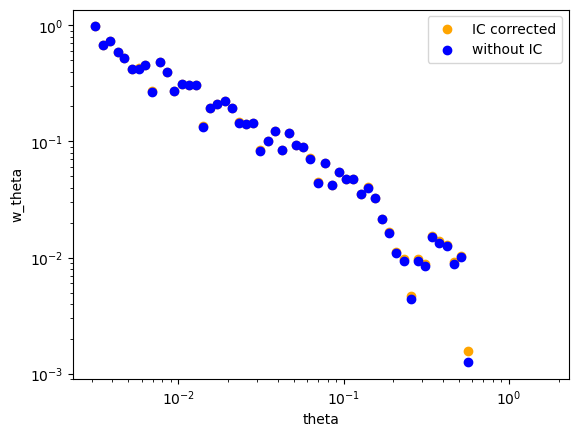

Subsample 6:
[ 6.06384930e-02  3.04506807e-02  5.52662519e-02  1.75380545e-01
  1.71329678e-03  1.09971236e-01  1.18360302e-01  1.24186635e-02
  8.45187870e-02  4.52109476e-02  2.54838892e-02  5.51274838e-02
  5.36755799e-02  7.27349798e-02  6.91535517e-02  3.93502301e-02
  2.45162512e-02  5.28680759e-02  2.75777388e-02  3.97248541e-02
  1.43941879e-02  2.68369834e-02  3.23576863e-02  2.68822474e-02
  3.66281495e-02  1.49606970e-02  2.37094167e-02  2.81442419e-02
  2.49154688e-02  1.40383054e-02  2.24122595e-02  1.60292565e-02
  1.69511412e-02  1.12450168e-02  1.02824450e-02  1.42263445e-02
  6.38371073e-03  6.08251022e-03  9.15851179e-03  6.98529147e-03
  4.57728021e-03  2.09669027e-03  4.04996922e-03  6.91935021e-03
  1.60531474e-03  6.33991597e-04  2.46905391e-03  2.69651772e-03
  2.56334297e-03  8.51345861e-04  4.72388848e-03 -8.85081506e-04
 -2.58893699e-04 -2.14066310e-03 -1.08275266e-03  1.20760959e-04
  2.07724077e-04 -3.22726418e-03 -1.11723924e-03 -1.26762230e-03
 -1.36498647

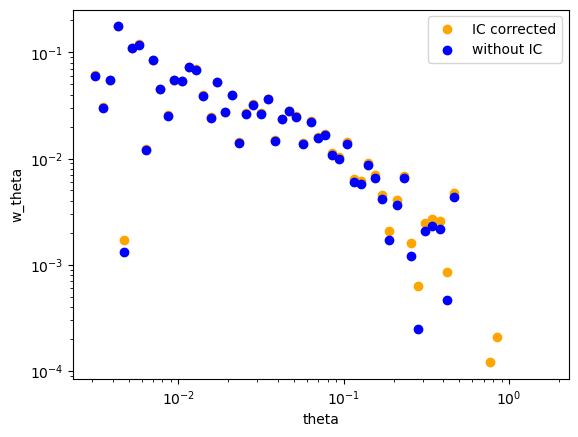

Subsample 7:
[ 3.90402014e-01  1.61439097e-01  2.18320625e-01  2.60934109e-01
  2.64585447e-01  2.34972825e-01  1.63690204e-01  1.94278526e-01
  1.78758247e-01  2.42617315e-01  1.38397001e-01  2.13334242e-01
  1.90920372e-01  1.23435313e-01  6.90224275e-02  1.30571424e-01
  1.00826803e-01  8.08542847e-02  1.15661407e-01  1.26400704e-01
  3.93320594e-02  5.09079956e-02  9.67597534e-02  4.85360601e-02
  3.48985214e-02  5.27623096e-02  3.28814727e-02  4.66416112e-02
  4.25118763e-02  1.08384944e-02  4.15905654e-02  3.14016565e-02
  2.32130999e-02  3.17080646e-02  2.20503017e-02  2.88585523e-02
  1.90825898e-02  2.10545903e-02  1.84831134e-02  2.41451405e-02
  4.55429147e-03  3.39352108e-03  5.78860885e-03  4.89622253e-03
 -2.05995437e-03  5.71752954e-03  4.71044037e-03  2.81079857e-03
  1.73272227e-04 -1.42316840e-03  1.26493979e-03  2.00026254e-03
 -7.63643144e-04 -4.48238903e-03 -1.88013920e-03 -1.42808800e-03
 -1.30415653e-03 -4.01022912e-03 -3.60956517e-03  4.91132497e-04
 -9.03321379

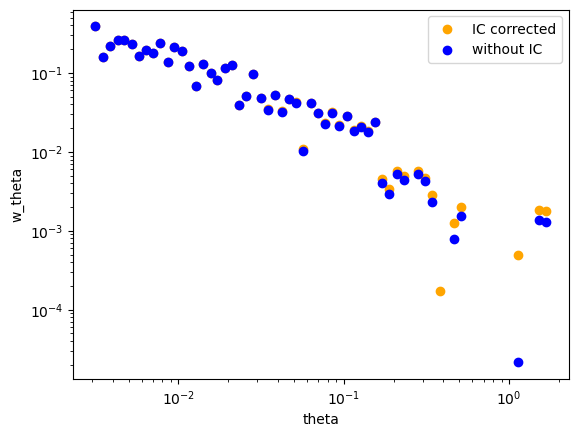

Subsample 8:
[ 6.26567299e-01  1.18656118e+00  5.46743152e-01  6.70022250e-01
  4.38200309e-01  3.64313042e-01  3.52909458e-01  5.89992718e-01
  3.75709526e-01  3.36570852e-01  2.70298450e-01  2.38073860e-01
  2.76324920e-01  3.36802865e-01  1.62422216e-01  1.91267190e-01
  1.31330122e-01  1.41286176e-01  1.60973877e-01  1.07786750e-01
  9.15375868e-02  1.32025908e-01  1.29681785e-02  8.48302366e-02
  7.63269391e-02  7.28247449e-02  6.07864547e-02  5.82480770e-02
  5.45195278e-02  5.63402584e-02  2.84900901e-02  4.24122515e-02
  4.93852546e-02  1.73084037e-02  2.74707673e-02  3.63247608e-02
  2.74385066e-02  2.44603707e-02  1.45734073e-02  3.32051076e-02
  8.92629485e-03  8.78624619e-03  1.18284280e-02  8.87473516e-03
  1.21272815e-02  1.27662271e-02  5.61720972e-03  9.51462327e-03
  4.40847288e-03  2.72182120e-03  8.37815674e-03  5.95318753e-04
  9.61475589e-05 -2.81004276e-06 -8.87682510e-04 -3.55335464e-03
 -2.67236805e-03 -7.66909973e-03 -1.16545387e-02 -4.51410714e-03
 -6.75921661

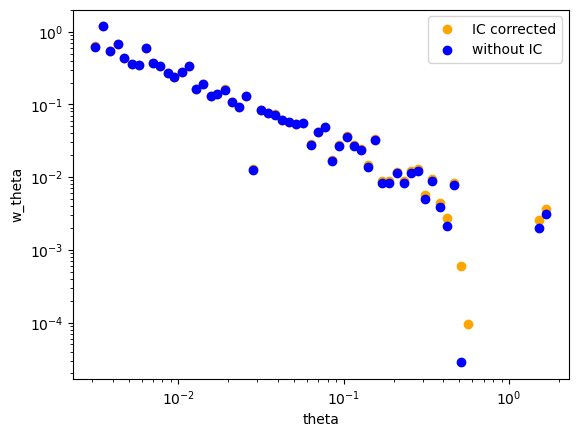

Subsample 9:
[ 0.0601972   0.03906931  0.0764508   0.01477356  0.03204732  0.03648801
  0.04057034  0.02057886  0.00103251  0.08208354  0.03161287  0.04430412
  0.07390104  0.0126111   0.01873289  0.04183855  0.02011677  0.01167877
  0.00749443  0.02115797  0.02257545  0.0098855   0.02764825  0.01725642
  0.01131693  0.02082298  0.00942931  0.02080876  0.00804059  0.01450391
  0.0159915   0.01822738  0.00941191  0.00899081  0.01118805  0.00908748
  0.0086267   0.00739096  0.00866441  0.00847472  0.00753619  0.00325866
  0.0060967   0.00317729  0.00496223  0.00252667  0.00215426  0.00204337
  0.00231627  0.00087674  0.00238583  0.00089816  0.0008811   0.0006539
 -0.00047753 -0.00109509 -0.00187395 -0.00233946 -0.00087369 -0.00059373
 -0.00152677  0.00097376  0.00222924 -0.0010476 ]


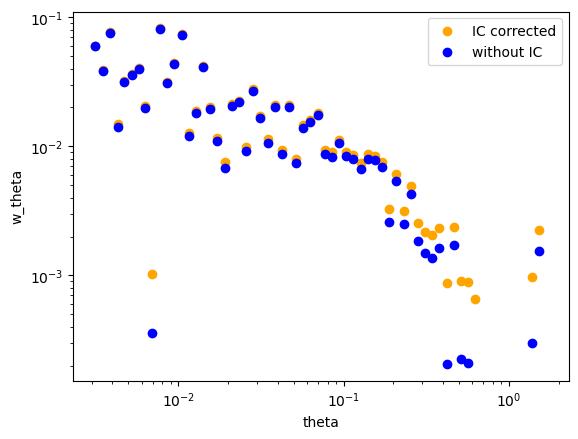

Subsample 10:
[ 4.28267822e-01  3.31098295e-01  2.77133970e-01  3.87610516e-01
  2.40738342e-01  3.04144967e-01  2.62016555e-01  1.99835758e-01
  2.44648162e-01  2.74583809e-01  1.90164886e-01  1.53566128e-01
  1.34225035e-01  2.08024504e-01  2.04739368e-01  1.50094299e-01
  1.35014713e-01  1.29270595e-01  1.37714264e-01  1.30995420e-01
  1.25913081e-01  1.06966643e-01  1.28298291e-01  1.04055146e-01
  6.66546278e-02  8.43926734e-02  6.65731043e-02  8.20755352e-02
  6.07910630e-02  6.93036076e-02  5.26167754e-02  6.31999636e-02
  4.71977776e-02  5.05207250e-02  5.24065738e-02  4.85516659e-02
  3.45556954e-02  3.66055100e-02  2.77453402e-02  2.97515839e-02
  2.71214091e-02  2.43729479e-02  1.72860919e-02  1.54198992e-02
  1.91171116e-02  1.48831630e-02  1.29689152e-02  7.96066509e-03
  6.13552920e-03  9.91777467e-03 -3.45980023e-04  1.07821459e-03
 -4.26231540e-03 -5.67860162e-03 -5.98093581e-03 -3.83483983e-03
 -6.54255587e-03 -7.57545623e-03 -8.20661911e-03 -6.23523531e-03
 -1.8781203

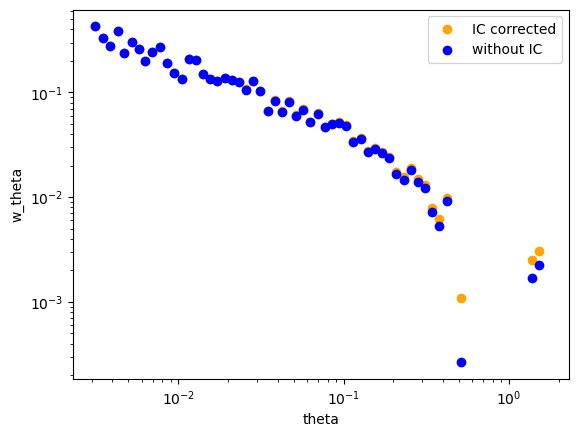

Subsample 11:
[ 0.81966105  1.02977194  0.62221028  0.39683322  0.64485302  0.58873745
  0.39811976  0.50325251  0.40153972  0.43870587  0.24203144  0.4068232
  0.35114128  0.1985347   0.25529194  0.3228378   0.1891101   0.24838268
  0.20808231  0.25990829  0.12594321  0.17076897  0.16391922  0.15335774
  0.12523963  0.10028355  0.12307202  0.12178783  0.08187669  0.08588597
  0.0991001   0.07770605  0.06000728  0.0702489   0.06047716  0.06111752
  0.06402306  0.03643261  0.04634027  0.04194197  0.03481609  0.02900067
  0.02295553  0.01644447  0.01343064  0.01597298  0.01631181  0.01319322
  0.00992168  0.01150184  0.00913761 -0.0013706   0.00334407 -0.00249562
 -0.00557231 -0.01080842 -0.00911569 -0.01759526 -0.01437951 -0.00851936
 -0.00352933 -0.00110479  0.00520981 -0.00315129]


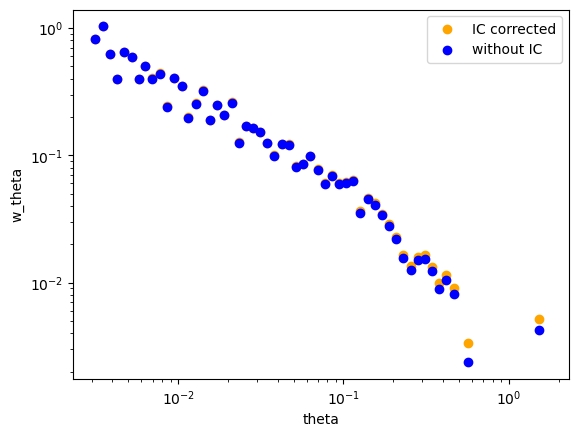

Subsample 12:
[-1.47575234e-03  5.86435510e-02  2.97378980e-02  4.11882281e-02
  1.49088808e-02  5.13390272e-02  2.00039943e-02  4.97302920e-02
  2.32289193e-02  1.88384343e-02  3.48998061e-02  2.04226670e-02
  2.05137109e-02  1.99698564e-02  1.98446749e-02  2.56726131e-02
  3.44369026e-02  9.72174178e-03  2.88414356e-03  1.96369146e-02
  1.43796449e-02  1.91237915e-02  1.13799678e-02  1.24802080e-02
  8.59429618e-03  1.10938758e-02  1.05653912e-02  9.87529843e-03
  7.91590722e-03  3.47164809e-03  1.33216711e-02  9.30447312e-03
  6.97095733e-03  7.03608353e-03  6.63443703e-03  1.10216732e-02
  3.43950733e-03  2.67760805e-03  4.81557367e-03  4.45503890e-03
  4.59942159e-03  4.40027522e-03  5.38728251e-03  5.36372064e-03
  2.62599637e-03 -5.98228709e-04  1.40353657e-03  1.14407380e-03
  4.27157261e-03 -1.14929593e-03  2.96759787e-03  1.06673433e-03
  1.64219058e-05  9.51257596e-04  8.00872633e-04 -4.36907343e-04
  8.15732815e-05 -3.56526731e-04  4.40686312e-04  5.80855873e-05
  5.5686980

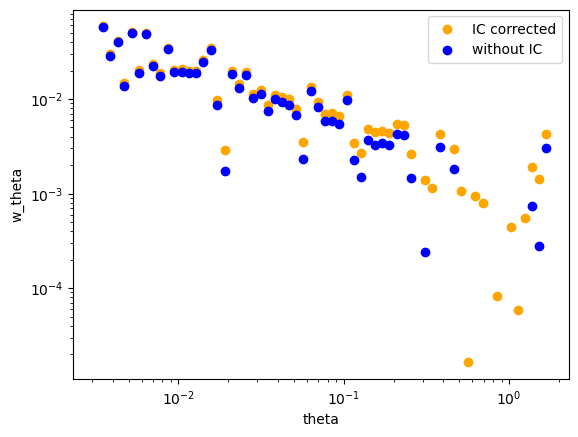

Subsample 13:
[ 0.50558997  0.34442682  0.37010183  0.14847712  0.28471426  0.33798061
  0.26737006  0.18517947  0.20771044  0.22478853  0.18792864  0.17767204
  0.18081813  0.17887361  0.15624471  0.10778815  0.14120487  0.11517577
  0.09941629  0.13842041  0.11988458  0.12145884  0.0764378   0.08933402
  0.05603136  0.07056301  0.08076508  0.07636602  0.06053783  0.05585051
  0.05818757  0.05232064  0.04994346  0.0440354   0.04796393  0.03559834
  0.03816607  0.03499077  0.02976509  0.03527583  0.02606145  0.02391281
  0.01853342  0.01752085  0.01327054  0.01018507  0.01503333  0.01252021
  0.00981082  0.00979384  0.00386151  0.00604357  0.00165439  0.00105728
 -0.00089021 -0.00615657 -0.00670657 -0.00601673 -0.00805893 -0.00948964
 -0.0069231  -0.00091789 -0.00411182 -0.00355127]


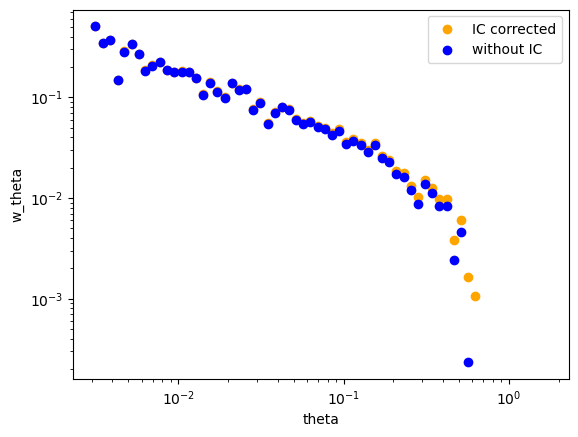

Subsample 14:
[ 7.22677257e-01  6.83395936e-01  5.40370663e-01  4.45299352e-01
  6.51677148e-01  5.16143736e-01  4.78174425e-01  5.09209546e-01
  4.47918331e-01  3.23627106e-01  2.93731415e-01  3.04892945e-01
  3.54063793e-01  3.11589457e-01  2.23509129e-01  1.99600493e-01
  2.82971354e-01  1.97767456e-01  2.18780408e-01  1.63171309e-01
  1.48098992e-01  1.51140838e-01  1.43565959e-01  1.27446877e-01
  1.38705812e-01  1.22333889e-01  8.82570459e-02  1.19489023e-01
  1.04787523e-01  8.31169093e-02  5.47827344e-02  6.03330790e-02
  7.18413367e-02  5.86320420e-02  5.23915865e-02  5.14297694e-02
  4.99104092e-02  4.40415668e-02  4.41212766e-02  4.85677327e-02
  3.08014995e-02  2.76257604e-02  3.02171465e-02  2.03664782e-02
  1.88077460e-02  1.33817788e-02  1.14529344e-02  1.35567206e-02
  8.41701442e-03  6.02097072e-03  6.26653149e-03  3.89196871e-03
  1.03216601e-03  1.92604975e-03  3.60500185e-04 -8.98973445e-03
 -7.42845899e-03 -3.80897635e-03 -9.79248039e-03 -1.29957177e-02
 -8.2827593

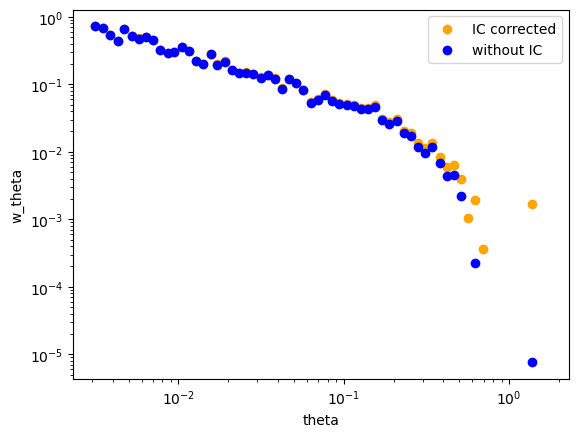

Subsample 15:
[0.06369817 0.06245471 0.04241241 0.02507391 0.01865975 0.02984965
 0.02461304 0.01714447 0.01859437 0.01640136 0.01807971 0.00805002
 0.02025576 0.01685394 0.01616864 0.01109636 0.02137547 0.01558276
 0.01384967 0.01863894 0.01178359 0.0213816  0.01154788 0.01089462
 0.01397289 0.01571468 0.01075043 0.00759184 0.01425212 0.00865754
 0.00939784 0.00727605 0.00525123 0.00585121 0.00439722 0.00862439
 0.00511547 0.0044436  0.00665613 0.00346603 0.0036038  0.00154643
 0.00301502 0.00485946 0.0021244  0.0034459  0.0029427  0.00225478
 0.00286638 0.00140428 0.00265534 0.00155693 0.00258538 0.00136322
 0.00200414 0.00057143 0.00151123 0.00159575 0.0010721  0.00093983
 0.00140647 0.00175221 0.00143761 0.00461632]


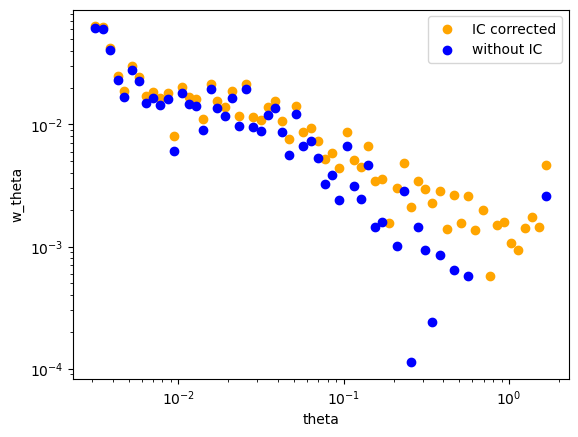

Subsample 16:
[ 0.26421675  0.19155872  0.31489195  0.27770097  0.20911087  0.22691159
  0.23814271  0.14682666  0.15586594  0.14637438  0.17296804  0.18849305
  0.10550036  0.15420944  0.08196305  0.12765294  0.12482345  0.11124855
  0.07289901  0.08496442  0.05774563  0.06663248  0.05155118  0.06560911
  0.05456756  0.04622581  0.0458446   0.03220084  0.03734493  0.03625705
  0.04050495  0.03294908  0.02105915  0.02896468  0.02487936  0.02212099
  0.02086121  0.02201885  0.02552804  0.01934595  0.01425699  0.0143948
  0.01172889  0.00917538  0.01132351  0.00930702  0.00977554  0.00802058
  0.00822685  0.00708473  0.00585685  0.00601053  0.00064141 -0.00162758
 -0.00300151 -0.00154675 -0.00199695 -0.00362319 -0.00224432 -0.00079944
  0.00098183  0.00150772 -0.00137668 -0.00309337]


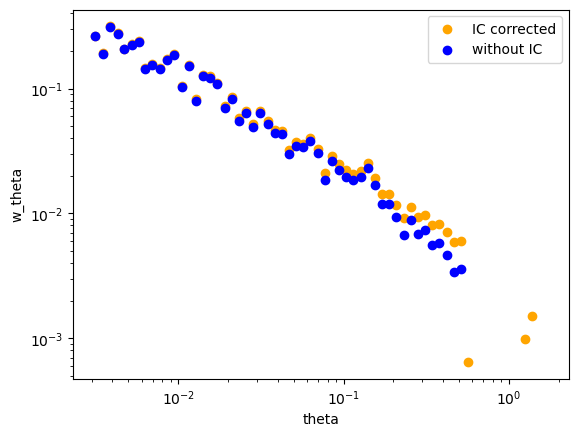

Subsample 17:
[ 6.27203765e-01  7.79385219e-01  6.94210103e-01  6.12550850e-01
  4.68420717e-01  7.25088643e-01  7.22569971e-01  4.82551370e-01
  3.19834754e-01  4.39744310e-01  3.65653481e-01  2.77808041e-01
  3.24943055e-01  2.25171090e-01  2.82893057e-01  1.68050001e-01
  1.95689924e-01  1.96182071e-01  1.65927844e-01  1.76949161e-01
  1.54632979e-01  8.04289555e-02  1.22763528e-01  8.78134675e-02
  1.12497993e-01  9.31462854e-02  6.53601811e-02  5.69197333e-02
  6.98913776e-02  6.49270741e-02  4.49734217e-02  6.11302973e-02
  5.30891866e-02  4.66762582e-02  4.33762039e-02  5.19406936e-02
  2.48015418e-02  3.10331537e-02  3.27550208e-02  2.38374314e-02
  1.39547888e-02  1.41039732e-02  2.62672957e-02  2.12189584e-02
  1.46072746e-02  1.32614076e-02  8.02380213e-03  1.09001696e-02
  4.39044501e-03  7.34175411e-03  9.00922741e-03  5.27093396e-03
  1.35173109e-04 -8.73612778e-04 -3.21174032e-03 -6.80371242e-03
 -5.83185928e-03 -4.63161967e-03 -4.10123160e-03 -3.99528443e-03
  2.6435415

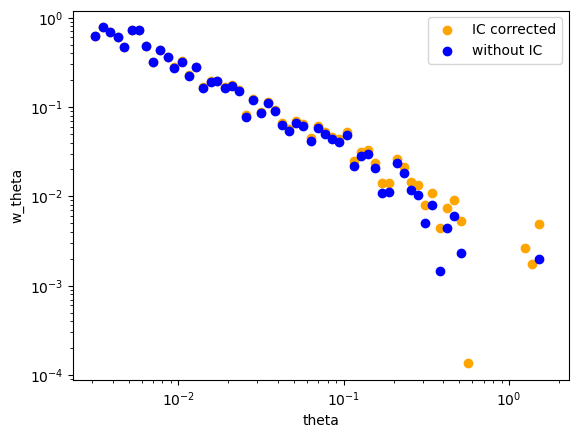

Subsample 18:
[0.00555492 0.07963004 0.03912769 0.07204841 0.01972216 0.00589719
 0.02307905 0.03400925 0.03173642 0.03557709 0.01583074 0.01836274
 0.01743994 0.02234491 0.02321017 0.01605977 0.02245545 0.01985714
 0.00687078 0.00410614 0.01646689 0.0112507  0.01310183 0.01404904
 0.01691538 0.00933966 0.01241838 0.01053953 0.01064341 0.0116015
 0.00766552 0.0068939  0.00993207 0.00672298 0.00937096 0.00977314
 0.00638054 0.00705105 0.00546981 0.00716469 0.00635519 0.00467296
 0.00528052 0.00455543 0.00513504 0.00248704 0.00473388 0.00353451
 0.00483948 0.00250085 0.00487509 0.00254379 0.00421933 0.00257472
 0.0032522  0.00278595 0.00339176 0.00274318 0.00227185 0.00283568
 0.00276646 0.00241604 0.0037737  0.0025868 ]


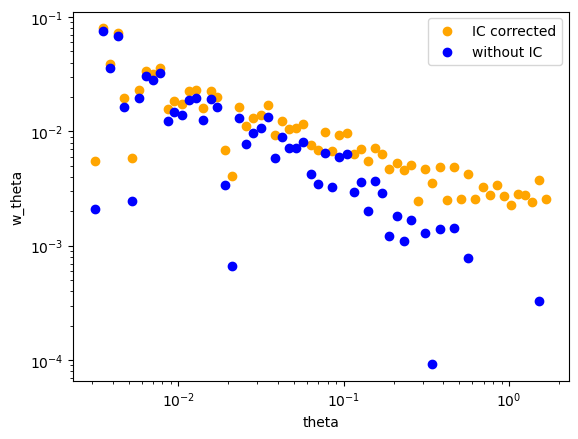

Subsample 19:
[ 0.23149169  0.27106733  0.15484758  0.14184845  0.12643204  0.19226846
  0.1379304   0.12096411  0.13024282  0.12641     0.10043141  0.12128069
  0.10627773  0.09184704  0.0922802   0.07498662  0.05144522  0.05497162
  0.0677323   0.06871451  0.08221795  0.05026141  0.05642542  0.04687456
  0.04966091  0.0655151   0.04907026  0.03874217  0.04704658  0.04185817
  0.03047602  0.04115069  0.03195909  0.03179055  0.03295927  0.02624825
  0.02211281  0.01708231  0.02306688  0.02084454  0.01459804  0.01524399
  0.01340928  0.01402114  0.01020544  0.00890952  0.00634865  0.00812743
  0.0053681   0.00527728  0.00456933  0.00310994  0.00164266 -0.00042213
 -0.00275705  0.00061852  0.00219533  0.00091515  0.00215783  0.0033667
  0.0058768   0.00359232 -0.000549   -0.00302681]


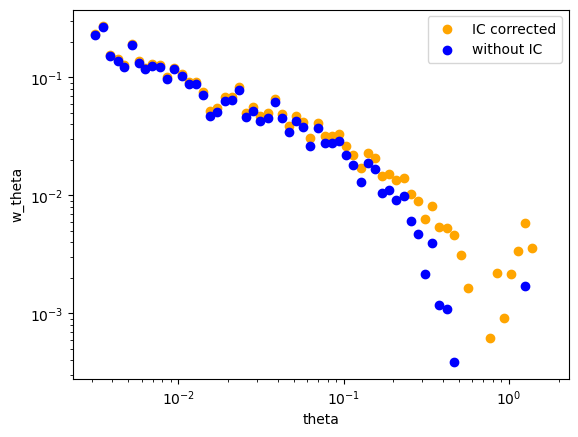

Subsample 20:
[ 5.58027651e-01  7.26938348e-01  6.80656404e-01  5.71307180e-01
  5.37508811e-01  4.62718281e-01  5.14010731e-01  3.99760101e-01
  4.00663988e-01  4.34805371e-01  2.22533117e-01  2.67719803e-01
  2.63373087e-01  2.06950874e-01  1.73393670e-01  2.05122620e-01
  9.58295707e-02  2.18253048e-01  1.56037176e-01  1.38861278e-01
  1.25998013e-01  1.03848397e-01  1.52031282e-01  8.71792360e-02
  7.92609404e-02  7.43905734e-02  9.47681318e-02  8.49307345e-02
  8.87895152e-02  6.99962552e-02  7.75772660e-02  7.37968927e-02
  5.29446714e-02  5.90529992e-02  6.28973087e-02  5.42067431e-02
  4.59365722e-02  3.28732987e-02  3.70102600e-02  3.13740516e-02
  2.12208880e-02  2.84700350e-02  2.27958407e-02  1.75973725e-02
  1.68770470e-02  1.67082831e-02  1.97742073e-02  1.75350068e-02
  1.73004337e-02  1.66352481e-02  4.19935376e-03  8.16906342e-03
 -1.00117238e-04 -5.74814343e-03 -3.42844965e-03 -1.85620315e-03
 -4.71566282e-04 -4.01784192e-03 -1.52119817e-03  1.80441323e-04
  2.0929203

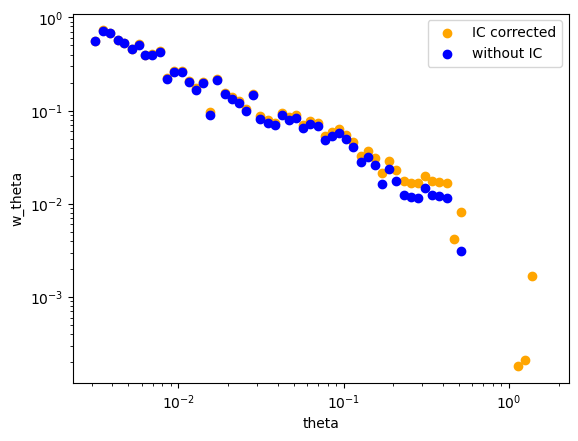

In [915]:
for i, result in enumerate(column_sums): 
    print(f"Subsample {result['catalog_index']}:")
    theta = np.array(theta)  
    
    # Calculate w_fit
    w_fit = 2 * 1e-2 * theta**(-0.8)
    
    # Calculate w_IC
    sum_rr = np.array(result['sum_rr'])  
    w_IC = np.sum(w_fit * sum_rr[i] / np.sum(sum_rr))  # IC = w_fit * RR(theta) / SUM(RR)
    
    # Calculate total w
    w = w_thetas[i] + w_IC  # w_measured + w_IC 
    print(w)
    
    plt.scatter(theta, w, label='IC corrected', color='orange')
    plt.scatter(theta, w_thetas[i], marker='o', label='without IC', color='blue')  # without IC



    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("theta")
    plt.ylabel("w_theta")
    plt.legend()
    plt.show()


In [916]:

# wobs(theta)= b**2 * wdm(theta)
def w_model(wdm, b):
    return wdm*(b**2)


In [917]:
"""z_values = np.arange(0.3, 1.1, 0.1)  ### be careful about completness issues, maybe stop at 0.4 for high SM


biases = []
bias_errors = []

for i in range(21):
    matter_corr = gg.angular_corr_matter  # Matter correlation function (theoretical values)
    galaxy_corr = w_thetas[i][mask]  # Galaxy correlation function (observed values)   
    galaxy_corr = np.array(galaxy_corr)
    matter_corr = np.array(matter_corr)

    # Align the dimensions of matter_corr and galaxy_corr
    min_length = min(len(matter_corr), len(galaxy_corr))
    matter_corr = matter_corr[:min_length]
    galaxy_corr = galaxy_corr[:min_length]
    
    
    popt, pcov = curve_fit(w_model, matter_corr, galaxy_corr)  # Initial guess for b = 1.0 , p0=[1.0]
    
    bias = popt[0]  # Best-fit bias for this subsample
    bias_error = np.sqrt(np.diag(pcov))[0]  # Uncertainty in bias
    
    
    # (1/ np.sqrt(sum_dd) * w_theta


    biases.append(bias)
    bias_errors.append(bias_error)

    print(f"Subsample {i + 1}:Bias: {bias:.3f} ± {bias_error:.3f}")
    print()

"""

'z_values = np.arange(0.3, 1.1, 0.1)  ### be careful about completness issues, maybe stop at 0.4 for high SM\n\n\nbiases = []\nbias_errors = []\n\nfor i in range(21):\n    matter_corr = gg.angular_corr_matter  # Matter correlation function (theoretical values)\n    galaxy_corr = w_thetas[i][mask]  # Galaxy correlation function (observed values)   \n    galaxy_corr = np.array(galaxy_corr)\n    matter_corr = np.array(matter_corr)\n\n    # Align the dimensions of matter_corr and galaxy_corr\n    min_length = min(len(matter_corr), len(galaxy_corr))\n    matter_corr = matter_corr[:min_length]\n    galaxy_corr = galaxy_corr[:min_length]\n    \n    \n    popt, pcov = curve_fit(w_model, matter_corr, galaxy_corr)  # Initial guess for b = 1.0 , p0=[1.0]\n    \n    bias = popt[0]  # Best-fit bias for this subsample\n    bias_error = np.sqrt(np.diag(pcov))[0]  # Uncertainty in bias\n    \n    \n    # (1/ np.sqrt(sum_dd) * w_theta\n\n\n    biases.append(bias)\n    bias_errors.append(bias_error)\n\n

In [927]:
biases = []
bias_errors = []

#errors = (1 / np.sqrt(sum_dd)) * w_theta 
#errors = np.array(errors)


    
for i, result in enumerate(column_sums): 

    matter_corr = gg.angular_corr_matter  # Matter correlation function (theoretical values)
    
    ## Without mask
    #galaxy_corr = w_thetas[i]    # Galaxy correlation function (observed values)
    
    ## With mask
    #galaxy_corr = w_thetas[i][mask]
    
    galaxy_corr = w

    
    #galaxy_corr = np.array(galaxy_corr)
    #matter_corr = np.array(matter_corr)
    
   

    # Align the dimensions of matter_corr and galaxy_corr
    min_length = min(len(matter_corr), len(galaxy_corr))
    matter_corr = matter_corr[:min_length]
    galaxy_corr = galaxy_corr[:min_length]

    # Compute the errors based on the formula and match shape to galaxy_corr
    errors = (1 / np.sqrt(sum_dd[i])) * w
    
    errors= errors[:min_length]

    # Fit the model
    popt, pcov = curve_fit(w_model, matter_corr, galaxy_corr, sigma=errors, absolute_sigma=True)

    # Extract the bias and its error
    bias = popt[0]  # Best-fit bias for this subsample
    bias_error = np.sqrt(np.diag(pcov))[0]  # Uncertainty in bias

    biases.append(bias)
    bias_errors.append(bias_error)

    print(f"Subsample {i + 1}:Bias: {bias:.3f} ± {bias_error:.3f}")



TypeError: can't multiply sequence by non-int of type 'numpy.float64'

In [920]:
biases = []
bias_errors = []

for i, result in enumerate(column_sums):
    # Ensure matter_corr is defined correctly for each iteration
    matter_corr = gg.angular_corr_matter  # Theoretical values for this iteration
    
    # Define galaxy_corr properly for each iteration
    galaxy_corr = w_thetas[i]  # Update this if `w_thetas` needs masking or computation

    # Convert to numpy arrays for safe truncation and calculations
    matter_corr = np.array(matter_corr)
    galaxy_corr = np.array(galaxy_corr)

    # Align dimensions of matter_corr and galaxy_corr
    min_length = min(len(matter_corr), len(galaxy_corr))
    matter_corr = matter_corr[:min_length]
    galaxy_corr = galaxy_corr[:min_length]

    # Compute errors based on the given formula
    try:
        error = (1 / np.sqrt(sum_dd[i])) * galaxy_corr  # Ensure sum_dd[i] exists
    except IndexError:
        raise IndexError(f"sum_dd does not have enough entries for i={i}")

    # Ensure errors match truncated length
    error = error[:min_length]

    # Fit the bias model
    try:
        popt, pcov = curve_fit(w_model, matter_corr, galaxy_corr, sigma=error, absolute_sigma=True)
    except RuntimeError as e:
        print(f"Subsample {i + 1}: Curve fitting failed with error: {e}")
        biases.append(np.nan)
        bias_errors.append(np.nan)
        continue

    # Extract bias and bias error
    bias = popt[0]  # Best-fit bias
    bias_error = np.sqrt(np.diag(pcov))[0]  # Uncertainty in bias

    # Append results
    biases.append(bias)
    bias_errors.append(bias_error)

    # Print results
    print(f"Subsample {i + 1}: Bias: {bias:.3f} ± {bias_error:.3f}")
    print()


Subsample 1: Bias: 0.920 ± 0.015

Subsample 2: Bias: 2.587 ± 0.027

Subsample 3: Bias: 3.765 ± 0.032

Subsample 4: Bias: 1.242 ± 0.011

Subsample 5: Bias: 2.279 ± 0.019

Subsample 6: Bias: 3.418 ± 0.023

Subsample 7: Bias: 0.168 ± 0.003

Subsample 8: Bias: 2.055 ± 0.013

Subsample 9: Bias: 2.918 ± 0.016

Subsample 10: Bias: 0.119 ± 0.002

Subsample 11: Bias: 2.439 ± 0.012

Subsample 12: Bias: 3.385 ± 0.014

Subsample 13: Bias: 0.000 ± 3.766

Subsample 14: Bias: 2.248 ± 0.009

Subsample 15: Bias: 3.336 ± 0.011

Subsample 16: Bias: 0.704 ± 0.002

Subsample 17: Bias: 2.098 ± 0.006

Subsample 18: Bias: 3.480 ± 0.008

Subsample 19: Bias: 0.195 ± 0.001

Subsample 20: Bias: 1.790 ± 0.004

Subsample 21: Bias: 3.293 ± 0.006



In [921]:
print("Galaxy Correlation (w_thetas):", galaxy_corr)
print()
print("Matter Correlation (angular_corr_matter):", matter_corr)



Galaxy Correlation (w_thetas): [0.55299187 0.72190257 0.67562063 0.5662714  0.53247303 0.4576825
 0.50897495 0.39472432 0.39562821 0.42976959 0.21749734 0.26268402
 0.25833731 0.2019151  0.16835789 0.20008684 0.09079379 0.21321727
 0.1510014  0.1338255  0.12096223 0.09881262 0.1469955  0.08214346
 0.07422516 0.0693548  0.08973235 0.07989496 0.08375374 0.06496048]

Matter Correlation (angular_corr_matter): [0.09611382 0.08776687 0.07918705 0.07052668 0.06195472 0.05364872
 0.04578592 0.03853372 0.0320396  0.02641911 0.0217407  0.01800776
 0.01514484 0.01300127 0.01138205 0.01009555 0.00899171 0.0079753
 0.007      0.00605388 0.0051434  0.00428206 0.00348444 0.00276355
 0.00212916 0.00158724 0.00113945 0.00078324 0.00051211 0.00031537]


Subsample 0:


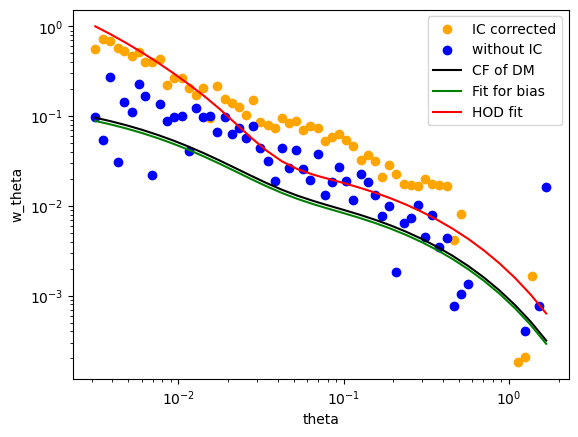

Subsample 1:


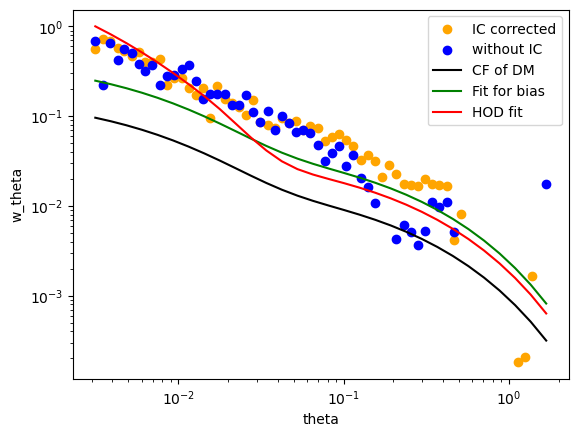

Subsample 2:


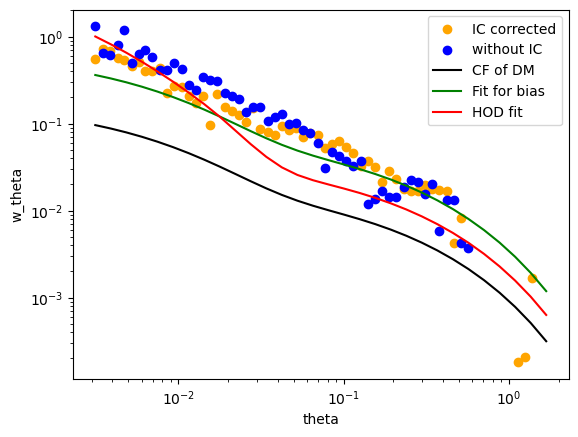

Subsample 3:


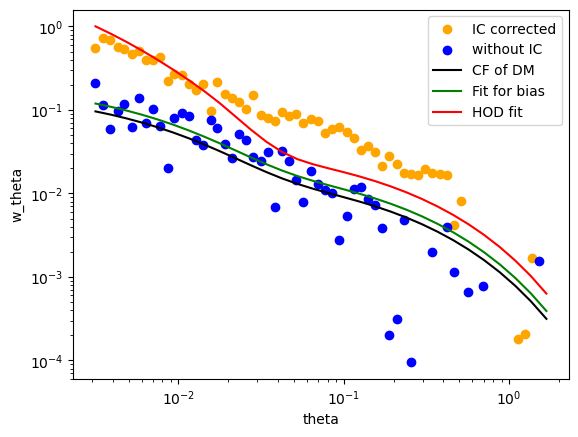

Subsample 4:


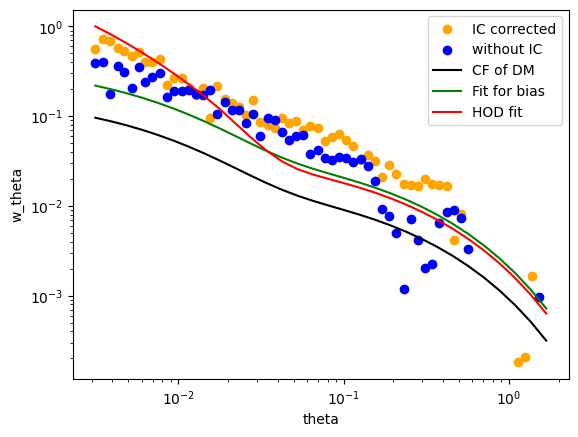

Subsample 5:


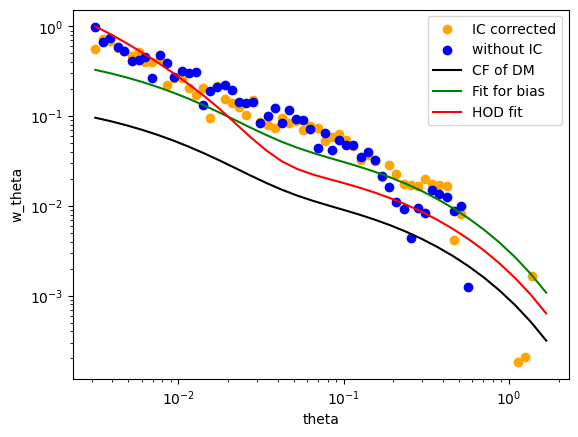

Subsample 6:


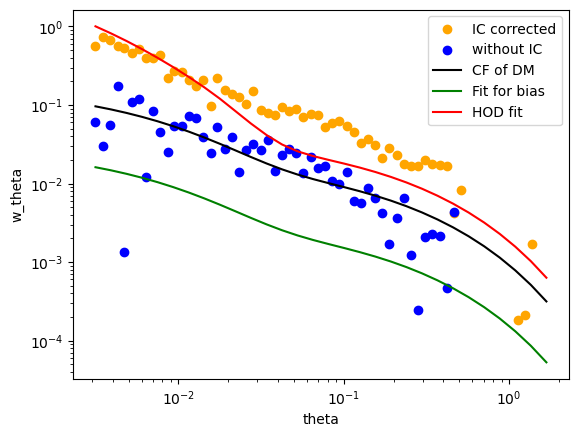

Subsample 7:


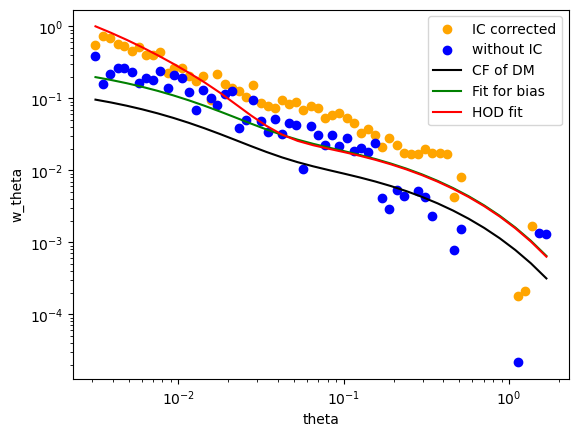

Subsample 8:


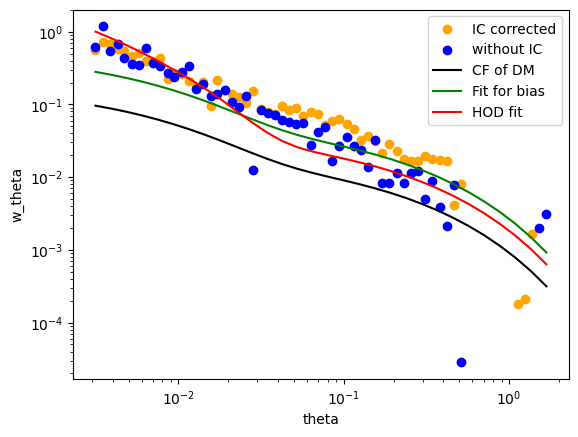

Subsample 9:


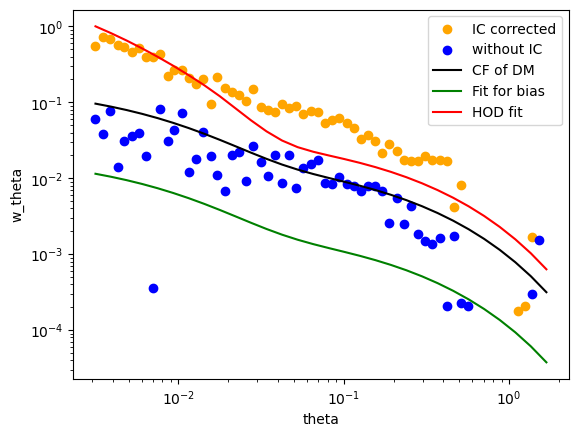

Subsample 10:


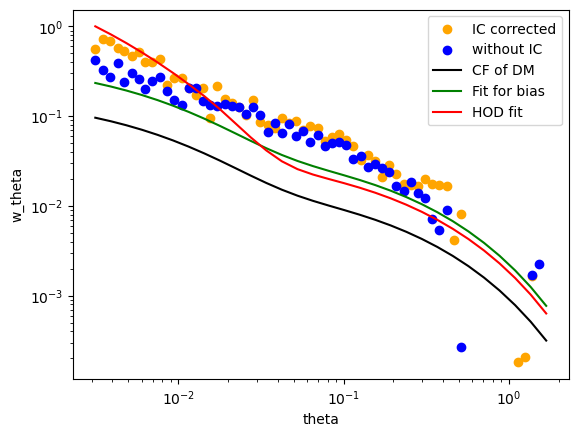

Subsample 11:


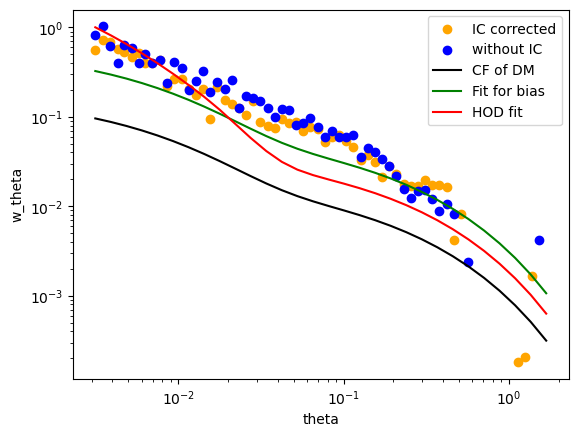

Subsample 12:


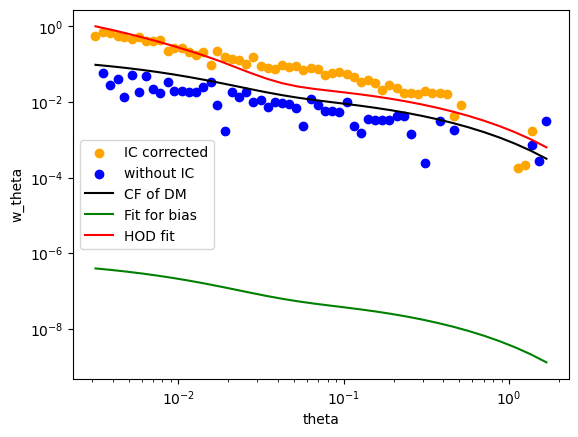

Subsample 13:


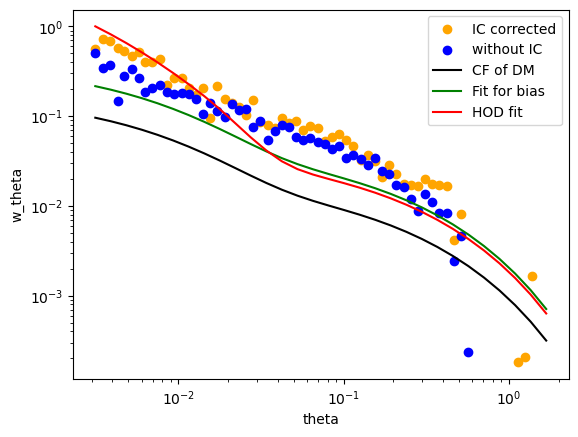

Subsample 14:


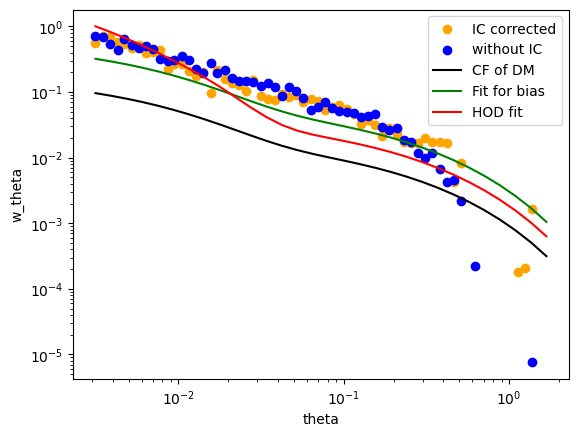

Subsample 15:


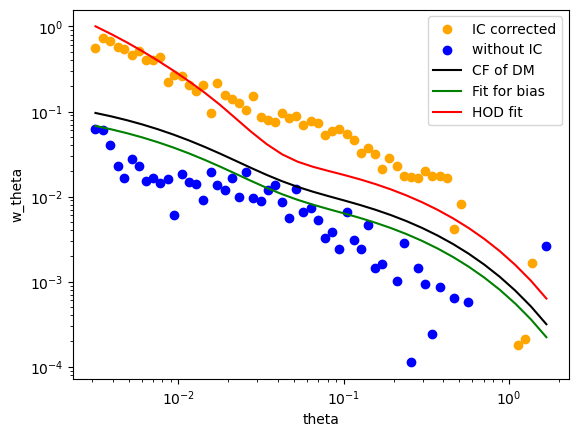

Subsample 16:


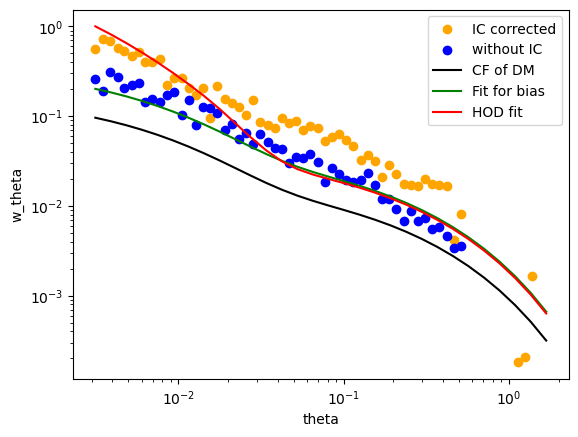

Subsample 17:


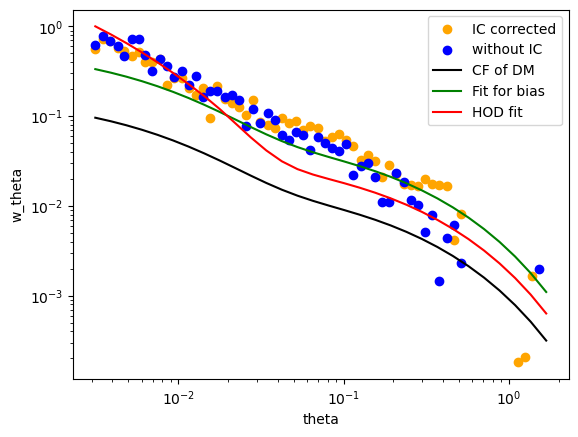

Subsample 18:


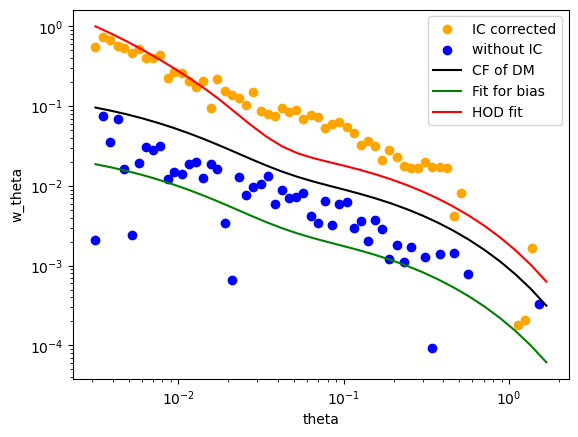

Subsample 19:


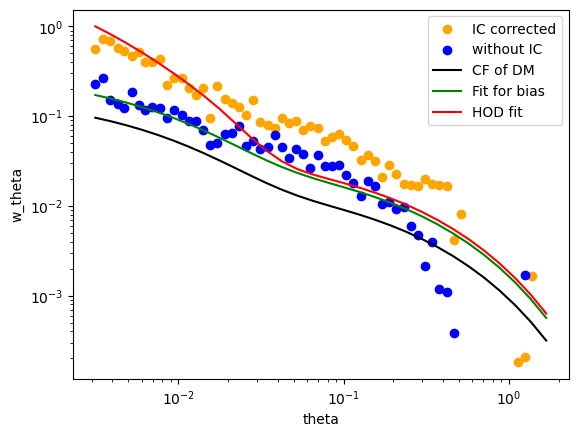

Subsample 20:


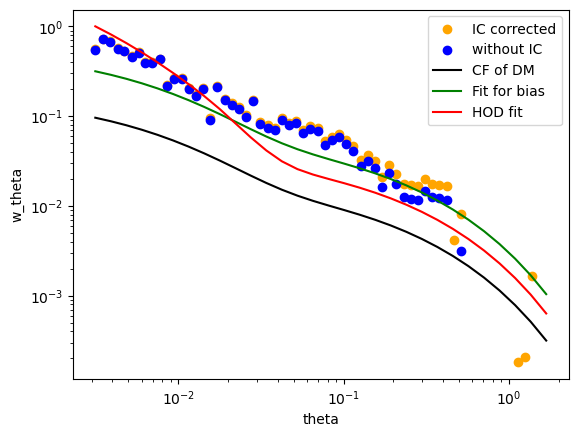

In [922]:
for i, result in enumerate(column_sums): 
    print(f"Subsample {result['catalog_index']}:")

    
    plt.scatter(theta, w, label='IC corrected', color='orange')
    plt.scatter(theta, w_thetas[i], marker='o', label='without IC', color='blue')  # without IC
    
    plt.plot(gg.theta*180/np.pi, gg.angular_corr_matter,'k-', label='CF of DM')
    plt.plot(gg.theta*180/np.pi, gg.angular_corr_matter*biases[i], 'g-', label='Fit for bias')
    plt.plot(gg.theta*180/np.pi, gg.angular_corr_gal, 'r-', label='HOD fit')


    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("theta")
    plt.ylabel("w_theta")
    plt.legend()
    plt.show()



In [885]:
"""
for i in range(21):
    # Compute the integral of the galaxy correlation function
    integral = np.trapz(w_thetas[i], theta)  

    scaled_bias = biases[i] / integral 
    scaled_w_theta = w_thetas[i] / integral 

    plt.scatter(theta, scaled_w_theta, marker='o', label=f"Subsample: {i + 1}", color='orange')  # With  integral correction
    plt.scatter(theta,  w_thetas[i], marker='o', label=f"Subsample: {i + 1}" ,color='blue')  # without integral correction


    # Plot the theoretical angular correlation function of dark matter (scaled)
    plt.plot(gg.theta * 180 / np.pi, gg.angular_corr_matter, 'k-', label='CF of DM')

    # Plot the fitted bias curve (scaled)
    plt.plot(gg.theta * 180 / np.pi, gg.angular_corr_matter * scaled_bias, 'g-', label='Fit for bias')

    # Plot the HOD fit (unscaled for comparison)
    plt.plot(gg.theta * 180 / np.pi, gg.angular_corr_gal, 'r-', label='HOD fit')

    # Add legend and labels
    plt.legend()
    plt.xscale("log")
    plt.yscale('log')
    plt.xlabel(r"$\theta$ (degrees)")
    plt.ylabel(r"$w_\theta$")
    plt.title(f"Subsample {i + 1}: Angular Correlation")
    plt.show()

"""

'\nfor i in range(21):\n    # Compute the integral of the galaxy correlation function\n    integral = np.trapz(w_thetas[i], theta)  \n\n    scaled_bias = biases[i] / integral \n    scaled_w_theta = w_thetas[i] / integral \n\n    plt.scatter(theta, scaled_w_theta, marker=\'o\', label=f"Subsample: {i + 1}", color=\'orange\')  # With  integral correction\n    plt.scatter(theta,  w_thetas[i], marker=\'o\', label=f"Subsample: {i + 1}" ,color=\'blue\')  # without integral correction\n\n\n    # Plot the theoretical angular correlation function of dark matter (scaled)\n    plt.plot(gg.theta * 180 / np.pi, gg.angular_corr_matter, \'k-\', label=\'CF of DM\')\n\n    # Plot the fitted bias curve (scaled)\n    plt.plot(gg.theta * 180 / np.pi, gg.angular_corr_matter * scaled_bias, \'g-\', label=\'Fit for bias\')\n\n    # Plot the HOD fit (unscaled for comparison)\n    plt.plot(gg.theta * 180 / np.pi, gg.angular_corr_gal, \'r-\', label=\'HOD fit\')\n\n    # Add legend and labels\n    plt.legend()\n  

len(m): 3
len(z): 7


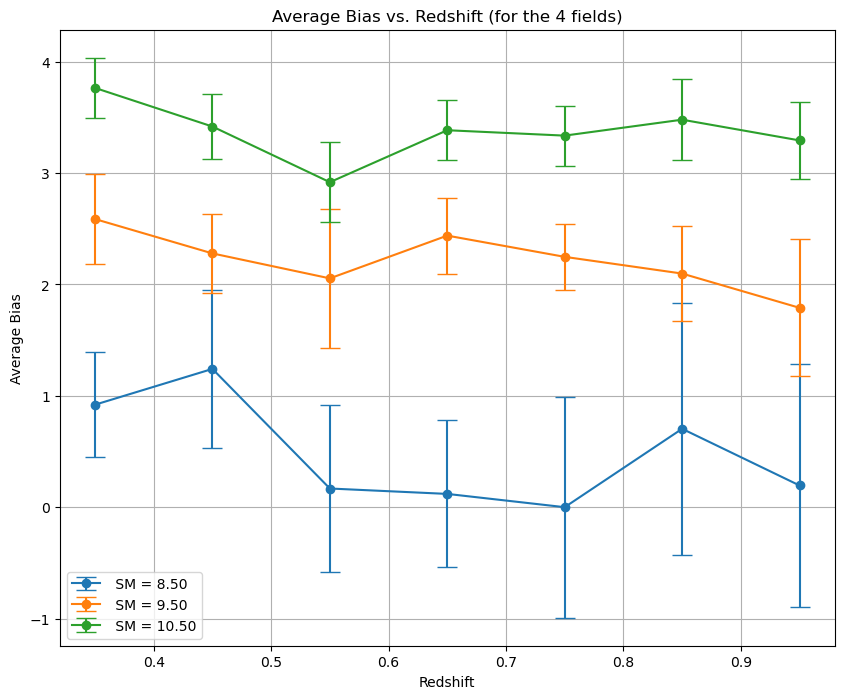

In [886]:
    
z_values = np.arange(0.3, 1.1, 0.1)  ### be careful about completness issues, maybe stop at 0.4 for high SM

#SM_range = np.linspace(9.5, 11, num=2) # High SM
#SM_range = np.linspace(8, 9.5, num=2) #Low SM
SM_range = np.linspace(8, 11, num=4) # diff SM
m = np.unique(SM_mean_range) # Get the unique SM values
z= z_mean_range

print('len(m):',len(m))
print('len(z):',len(z))

zm=np.meshgrid(m,z)
np.array(zm)
zm=np.array(zm).reshape(2,-1)
zm[:,0]


avg_bias = np.reshape(biases, (len(z), len(m))).T

#avg_bias_error= np.reshape(bias_errors, (len(z), len(m))).T

plt.figure(figsize=(10, 8)) 

for i in range(len(m)):
    plt.errorbar(z, avg_bias[i], yerr= avg_bias_error[i], label=f" SM = {m[i]:.2f}",marker='o',capsize=7)
    #plt.plot(z, avg_bias[i],  label=f" SM = {m[i]:.2f}",marker='o')
plt.title('Average Bias vs. Redshift (for the 4 fields)')
plt.xlabel('Redshift')
plt.ylabel('Average Bias')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(res,'Avgerage_bias'))
plt.show()

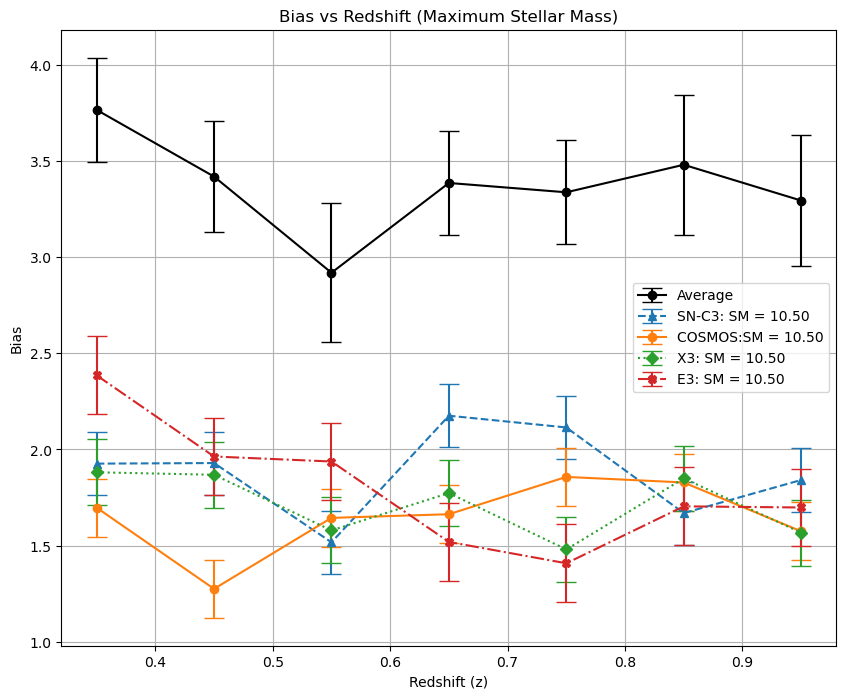

In [887]:
i_max = np.argmax(m)
plt.figure(figsize=(10, 8)) 

plt.errorbar(z, avg_bias[i_max], yerr= avg_bias_error[i_max], label=f"Average", color= 'black',marker='o',capsize=7)

plt.errorbar(z, C3_reshaped[i_max], yerr=C3[:, 2][i_max], label=f"SN-C3: SM = {m[i_max]:.2f}",marker="^", linestyle='dashed',capsize=7)
plt.errorbar(z, COSMOS_reshaped[i_max], yerr=COSMOS[:, 2][i_max], label=f"COSMOS:SM = {m[i_max]:.2f}", marker='o', capsize=7)
plt.errorbar(z, X3_reshaped[i_max],yerr=X3[:, 2][i_max],  label=f"X3: SM = {m[i_max]:.2f}",marker="D",linestyle='dotted',capsize=7)
plt.errorbar(z, E2_reshaped[i_max],yerr=E2[:, 2][i_max],  label=f"E3: SM = {m[i_max]:.2f}",marker="X",linestyle='dashdot',capsize=7)



# Add labels, title, grid, and legend
plt.xlabel("Redshift (z)")
plt.ylabel(r"Bias")
plt.title(r"Bias vs Redshift (Maximum Stellar Mass)")
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

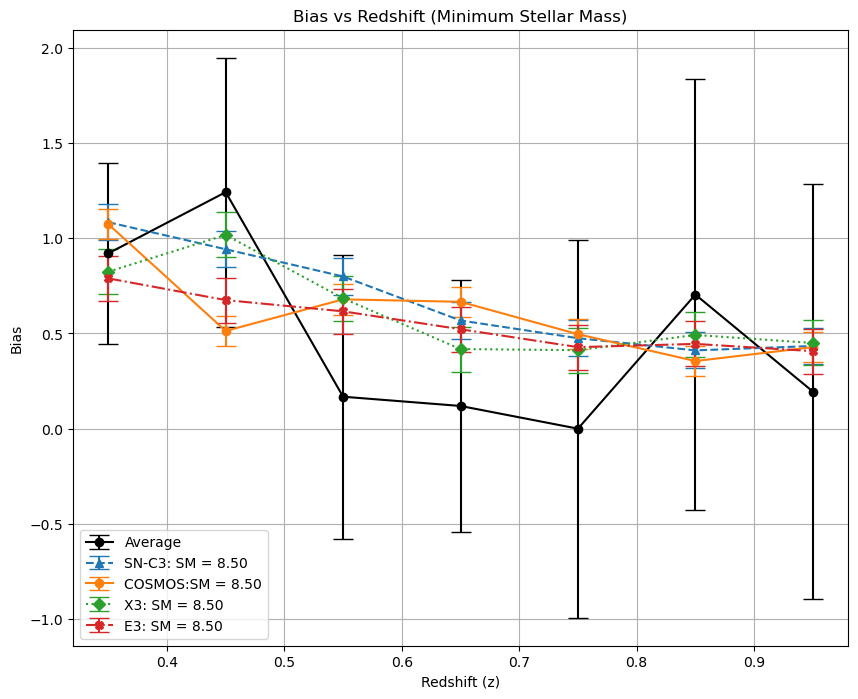

In [888]:
i_min = np.argmin(m)
plt.figure(figsize=(10, 8)) 

plt.errorbar(z, avg_bias[i_min], yerr= avg_bias_error[i_min], label=f"Average", color= 'black',marker='o',capsize=7)

plt.errorbar(z, C3_reshaped[i_min], yerr=C3[:, 2][i_min], label=f"SN-C3: SM = {m[i_min]:.2f}",marker="^", linestyle='dashed',capsize=7)
plt.errorbar(z, COSMOS_reshaped[i_min], yerr=COSMOS[:, 2][i_min], label=f"COSMOS:SM = {m[i_min]:.2f}", marker='o', capsize=7)
plt.errorbar(z, X3_reshaped[i_min],yerr=X3[:, 2][i_min],  label=f"X3: SM = {m[i_min]:.2f}",marker="D",linestyle='dotted',capsize=7)
plt.errorbar(z, E2_reshaped[i_min],yerr=E2[:, 2][i_min],  label=f"E3: SM = {m[i_min]:.2f}",marker="X",linestyle='dashdot',capsize=7)



plt.xlabel("Redshift (z)")
plt.ylabel(r"Bias")
plt.title(r"Bias vs Redshift (Minimum Stellar Mass)")
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

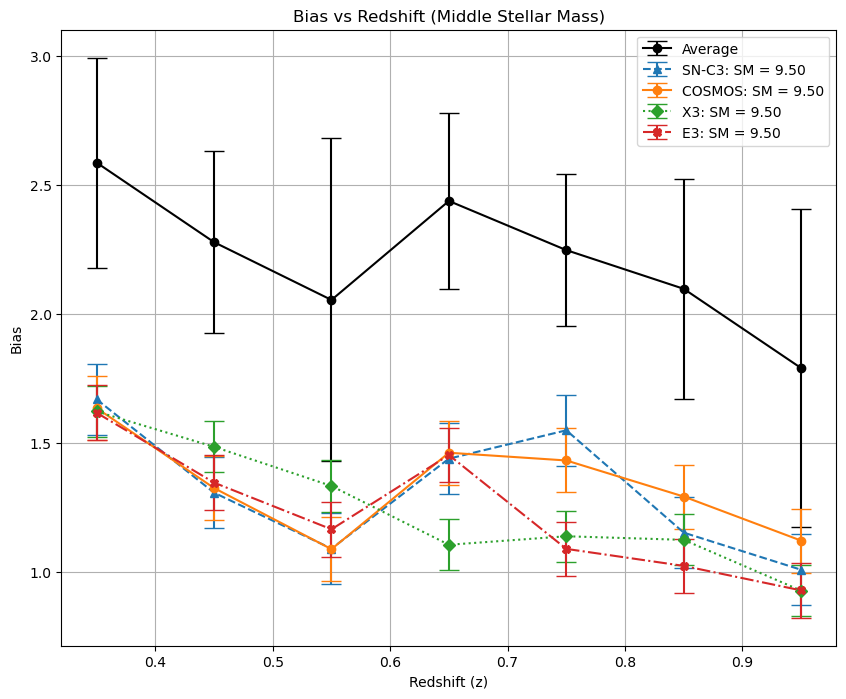

In [889]:
i_middle = len(m) // 2  # Middle index of m

plt.figure(figsize=(10, 8))

plt.errorbar(z, avg_bias[i_middle], yerr=avg_bias_error[i_middle], label=f"Average", color='black', marker='o', capsize=7)

plt.errorbar(z, C3_reshaped[i_middle], yerr=C3[:, 2][i_middle], label=f"SN-C3: SM = {m[i_middle]:.2f}", marker="^", linestyle='dashed', capsize=7)
plt.errorbar(z, COSMOS_reshaped[i_middle], yerr=COSMOS[:, 2][i_middle], label=f"COSMOS: SM = {m[i_middle]:.2f}", marker='o', capsize=7)
plt.errorbar(z, X3_reshaped[i_middle], yerr=X3[:, 2][i_middle], label=f"X3: SM = {m[i_middle]:.2f}", marker="D", linestyle='dotted', capsize=7)
plt.errorbar(z, E2_reshaped[i_middle], yerr=E2[:, 2][i_middle], label=f"E3: SM = {m[i_middle]:.2f}", marker="X", linestyle='dashdot', capsize=7)

plt.xlabel("Redshift (z)")
plt.ylabel(r"Bias")
plt.title(r"Bias vs Redshift (Middle Stellar Mass)")
plt.grid(True)
plt.legend()
plt.show()


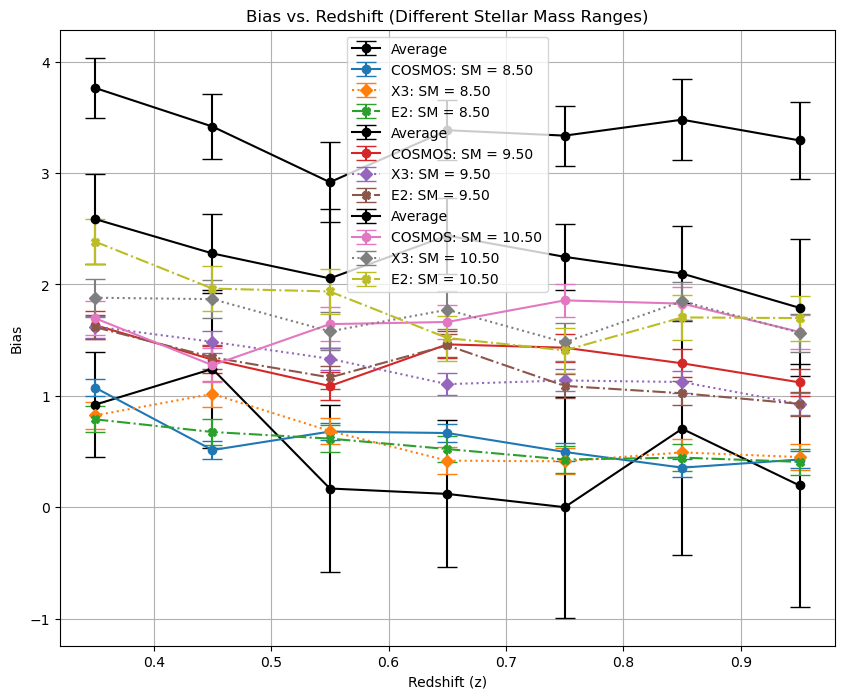

In [890]:
plt.figure(figsize=(10, 8)) 

for i in range(len(m)):
    plt.errorbar(z, avg_bias[i], yerr= avg_bias_error[i], label=f"Average",marker='o', color= 'black',capsize=7)

    plt.errorbar(z, COSMOS_reshaped[i],yerr=COSMOS[:, 2][i],  label=f"COSMOS: SM = {m[i]:.2f}",marker='o',capsize=7)
    plt.errorbar(z, X3_reshaped[i],yerr=X3[:, 2][i],  label=f"X3: SM = {m[i]:.2f}",marker="D",linestyle='dotted',capsize=7)
    plt.errorbar(z, E2_reshaped[i],yerr=E2[:, 2][i],  label=f"E2: SM = {m[i]:.2f}",marker="X",linestyle='dashdot',capsize=7)
    
plt.xlabel("Redshift (z)")
plt.ylabel(r"Bias")
plt.title(r"Bias vs. Redshift (Different Stellar Mass Ranges)")
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(res,"Bias_vs_z_for_diff_SM.png"))

plt.show()